In [2]:
import gzip
from tqdm.notebook import tqdm
propFileDict = {}
fileLineCount = 1225057250
with open('../../data/claims.w_removed_statements.tsv','r') as fin: 
    headerLine = next(fin)
    for line in tqdm(fin, total = fileLineCount):
        lineP = line.rstrip().split("\t")
        if "external-id" in lineP[-1]:
            continue
        prop = lineP[2]
        if prop not in propFileDict:
            propFileDict[prop] = open("../../propertiesSplit_WRemoved_Final/claims."+str(prop)+".tsv","w")
            propFileDict[prop].write(headerLine)
        propFileDict[prop].write(line)
    for file1 in propFileDict.values():
        file1.close()

  0%|          | 0/1149471184 [00:00<?, ?it/s]

# Generate Queries

## Type Constraint

### Understand Constraints File

In [3]:
import pandas as pd
df = pd.read_csv('../../constraintsOP/typeConstraint/claims.type-constraints_all.tsv',sep='\t')

In [4]:
df1 = df.groupby(['node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [5]:
df1.head()

,node1,label,node2
0,P1001,P2308,"[Q102496, Q105985, Q1140371, Q1151067, Q119768..."
1,P1001,P2309,[Q30208840]
2,P1002,P2308,[Q630010]
3,P1002,P2309,[Q21514624]
4,P1004,P2308,"[Q2221906, Q23413, Q3947, Q41176, Q88291]"


In [ ]:
df1[df1['node1'] == 'P8138']

### Query Generator

In [6]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 1

fOP = None

for prop in tqdm(df1.node1.unique()):
    try:
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
        relation = df1[(df1['node1'] == prop) & (df1['label'] == 'P2309')].node2.values[0][0]
        type1 = df1[(df1['node1'] == prop) & (df1['label'] == 'P2316')].node2.values
#         print(type1)

        parents = df1[(df1['node1'] == prop) & (df1['label'] == 'P2308')].node2.values[0]
        exceptions = df1[(df1['node1'] == prop) & (df1['label'] == 'P2303')].node2.values
        
        if relation == "Q21503252":
            parentFile = "P31"
            parentTitle = 'instanceOf'
        elif relation == "Q21514624":
            parentFile = "P279"
            parentTitle = 'subclass'
        else:
            parentFile = "isa"
            parentTitle = 'instanceOfOrSubclass'

        if len(type1) != 0 and type1[0][0] == "Q21502408":
            typeVal = "mandatory"
        elif len(type1) != 0 and type1[0][0] == "Q62026391":
            typeVal = "suggestion"
        else:
            typeVal = "normal"

        if len(exceptions):
            exceptionPart = "or node1 in " + str(exceptions[0]).replace("'",'"')
        else:
            exceptionPart = ""
        
        folderName = 'typeConstraint'
        shellFileSuffix = 'typeConstraintValidator'
        
        if cnt % 120 == 0:
            if fOP:
                fOP.close()
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
            fCnt += 1
        
        fOP.write("{ time (kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
        ../../wikidata-20210215/derived." + parentFile + ".tsv.gz \
        ../../wikidata-20210215/derived.P279star.tsv.gz \
        --match 'm: (node1)-[nodeProp]->(node2), " + parentFile + ": (node1)-[]->(nodex), P279star: (nodex)-[]->(par)' \
        --where 'par in " + str(parents).replace("'",'"') + " " + exceptionPart + "' \
        --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`' \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        --graph-cache ~/sqlite3_caches/type_new212_" + str(fCnt) + ".sqlite3.db; \
         kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
        --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv ;\
        kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv \
        ../../wikidata-20210215/derived." + parentFile + ".tsv.gz \
        --match 'm: (node1)-[nodeProp]->(node2), " + parentFile + ": (node1)-[]->(par)' \
        --where 'par in " + str(parents).replace("'",'"') + " " + exceptionPart + "' \
        --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`' \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        --graph-cache ~/sqlite3_caches/type_new212_" + str(fCnt) + ".sqlite3.db; \
         kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv \
        --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect.tsv ; \
         kgtk --debug cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct.tsv ; \
        ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n")

        cnt += 1
    except:
        print("Something failed for prop:",prop)

if fOP:
    fOP.close()

  0%|          | 0/4810 [00:00<?, ?it/s]

Something failed for prop: P1249
Something failed for prop: P6790


In [7]:
cnt

1465

In [8]:
# import os
# for i in range(1,14):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/typeConstraintValidator"+str(i)+".sh")
    

### Analyze Violations

In [33]:
import pandas as pd
import os
from tqdm.notebook import tqdm

typeConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt

propList = set()

violations = {}

for folder in tqdm(iter(['mandatory', 'suggestion', 'normal'])):
    typeConstViolations[folder] = {'instanceOf': {'correct': 0, 'incorrect': 0}, 'subclass': {'correct': 0, 'incorrect': 0}, 'instanceOfOrSubclass': {'correct': 0, 'incorrect': 0},'propCount': 0}
    filePath = "../../allConstraintsAnalysis_WRemoved_Final/typeConstraint_Final/"+folder+"/"
    for filename in tqdm(os.listdir(filePath)):
        type1 = filename.split(".")[2]
        prop = filename.split(".")[3]
        propList.add(prop)
        correctness = filename.split(".")[4]
        count1 = countLines(filePath+filename)
        typeConstViolations[folder][type1][correctness] += count1
        if prop not in violations:
            violations[prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        violations[prop][correctness] = count1
        violations[prop]['paths'].append(filePath+filename)
        if correctness == 'correct':
            typeConstViolations[folder]['propCount'] += 1
        

0it [00:00, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/2560 [00:00<?, ?it/s]

In [34]:
# countLines("../../allConstraintsAnalysis_WRemoved_Final/typeConstraint/mandatory/claims.type-constraints.subclass.P534.incorrect.tsv")

In [35]:
recordCount = 0
for elem in typeConstViolations.keys():
    for key1 in typeConstViolations[elem].keys():
        try:
            recordCount += typeConstViolations[elem][key1]['correct'] + typeConstViolations[elem][key1]['incorrect']
        except:
            continue
print(f"{len(propList)} properties processed for type constraint for {recordCount} statements")

1456 properties processed for type constraint for 510762035 statements


In [36]:
import pandas as pd
typeConstDF = pd.DataFrame(violations).T

In [37]:
typeConstDF['violation_ratio'] = typeConstDF.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)

In [38]:
typeConstDF.head()

,correct,incorrect,paths,violation_ratio
P742,48903,89,[../../allConstraintsAnalysis/typeConstraint_F...,0.001817
P2663,554,7,[../../allConstraintsAnalysis/typeConstraint_F...,0.012478
P5105,1919,95,[../../allConstraintsAnalysis/typeConstraint_F...,0.047170
P6938,3,2,[../../allConstraintsAnalysis/typeConstraint_F...,0.400000
P3179,5052,13,[../../allConstraintsAnalysis/typeConstraint_F...,0.002567


In [39]:
typeConstDF.sort_values(by=['violation_ratio','incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P8138,0,461,[../../allConstraintsAnalysis/typeConstraint_F...,1.0
P5051,0,64,[../../allConstraintsAnalysis/typeConstraint_F...,1.0
P2303,0,39,[../../allConstraintsAnalysis/typeConstraint_F...,1.0
P1227,0,19,[../../allConstraintsAnalysis/typeConstraint_F...,1.0
P2308,0,17,[../../allConstraintsAnalysis/typeConstraint_F...,1.0
P6001,0,16,[../../allConstraintsAnalysis/typeConstraint_F...,1.0
P8738,0,14,[../../allConstraintsAnalysis/typeConstraint_F...,1.0
P538,0,10,[../../allConstraintsAnalysis/typeConstraint_F...,1.0
P8004,0,6,[../../allConstraintsAnalysis/typeConstraint_F...,1.0
P5589,0,4,[../../allConstraintsAnalysis/typeConstraint_F...,1.0


In [40]:
list(typeConstDF.loc['P4945'].paths)

['../../allConstraintsAnalysis/typeConstraint_Final/normal/claims.type-constraints.instanceOf.P4945.correct.tsv',
 '../../allConstraintsAnalysis/typeConstraint_Final/normal/claims.type-constraints.instanceOf.P4945.incorrect.tsv']

In [1]:
!head ../../allConstraintsAnalysis_WRemoved_Final/typeConstraint_Final/normal/claims.type-constraints.instanceOf.P5051.incorrect.tsv

id	node1	label	node2	rank	node2;wikidatatype
Q10369487-P5051-Q4845565-75168cbb-0	Q10369487	P5051	Q4845565	normal	wikibase-item
Q12264664-P5051-Q1110918-cb778987-0	Q12264664	P5051	Q1110918	normal	wikibase-item
Q12264664-P5051-Q3394058-ac8798ff-0	Q12264664	P5051	Q3394058	normal	wikibase-item
Q12264664-P5051-Q801660-71c68e08-0	Q12264664	P5051	Q801660	normal	wikibase-item
Q1457751-P5051-Q6029401-3c0f721e-0	Q1457751	P5051	Q6029401	normal	wikibase-item
Q1457751-P5051-Q7643664-20983ead-0	Q1457751	P5051	Q7643664	normal	wikibase-item
Q1631914-P5051-Q3555260-04b1b724-0	Q1631914	P5051	Q3555260	normal	wikibase-item
Q2512768-P5051-Q493430-91955413-0	Q2512768	P5051	Q493430	normal	wikibase-item
Q2865993-P5051-Q9606-9312fd91-0	Q2865993	P5051	Q9606	normal	wikibase-item


In [43]:
typeConstDF['violation_ratio'].describe()

count    1456.000000
mean        0.095964
std         0.221602
min         0.000000
25%         0.000594
50%         0.008160
75%         0.054471
max         1.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Type Constraint Violation Ratios')

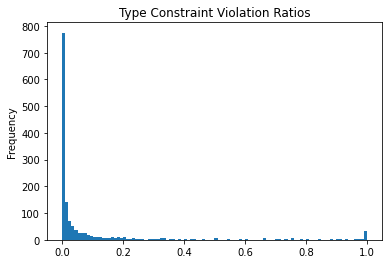

In [44]:
typeConstDF['violation_ratio'].plot.hist(bins=100).set_title("Type Constraint Violation Ratios")

Text(0.5, 1.0, 'Type Constraint Violation Ratios (<=0.05)')

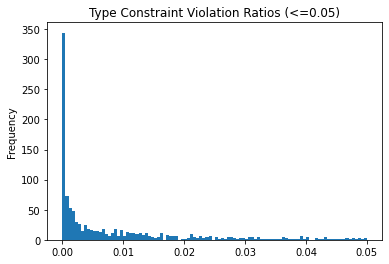

In [45]:
typeConstDF[typeConstDF['violation_ratio'] <= 0.05].violation_ratio.plot.hist(bins=100).set_title("Type Constraint Violation Ratios (<=0.05)")

In [46]:
print(f"No. of constraints whose violation ratio is greater than mean :{sum(typeConstDF['violation_ratio'] >= 5.286054)}/{len(typeConstDF)}")

No. of constraints whose violation ratio is greater than mean :0/1456


In [47]:
# typeConstDF.sort_values(by=['incorrect'],ascending=False).head(5).paths.values

In [48]:
# !cat ../../allConstraintsAnalysis_WRemoved_Final/typeConstraint/normal/claims.type-constraints.instanceOf.P953.incorrect.tsv

In [49]:
for key1 in typeConstViolations.keys():
    typeConstViolations[key1]['correct'] = typeConstViolations[key1]['instanceOf']['correct'] + typeConstViolations[key1]['subclass']['correct'] + typeConstViolations[key1]['instanceOfOrSubclass']['correct']
    typeConstViolations[key1]['incorrect'] = typeConstViolations[key1]['instanceOf']['incorrect'] + typeConstViolations[key1]['subclass']['incorrect'] + typeConstViolations[key1]['instanceOfOrSubclass']['incorrect']
    typeConstViolations[key1]['VR'] = typeConstViolations[key1]['incorrect'] / (typeConstViolations[key1]['correct'] + typeConstViolations[key1]['incorrect'])
        

In [50]:
typeConstViolations

{'mandatory': {'instanceOf': {'correct': 44768778, 'incorrect': 35027},
  'subclass': {'correct': 1966, 'incorrect': 30},
  'instanceOfOrSubclass': {'correct': 221394, 'incorrect': 204},
  'propCount': 165,
  'correct': 44992138,
  'incorrect': 35261,
  'VR': 0.0007831009736982587},
 'suggestion': {'instanceOf': {'correct': 61486, 'incorrect': 18368},
  'subclass': {'correct': 0, 'incorrect': 0},
  'instanceOfOrSubclass': {'correct': 23314, 'incorrect': 2939},
  'propCount': 11,
  'correct': 84800,
  'incorrect': 21307,
  'VR': 0.200806732826298},
 'normal': {'instanceOf': {'correct': 398100301, 'incorrect': 797888},
  'subclass': {'correct': 96605, 'incorrect': 9442},
  'instanceOfOrSubclass': {'correct': 66358710, 'incorrect': 265583},
  'propCount': 1280,
  'correct': 464555616,
  'incorrect': 1072913,
  'VR': 0.0023042252207016293}}

In [51]:
typeConstDF['total'] = typeConstDF['correct'] + typeConstDF['incorrect']
typeConstDF.sort_values(by=['total'],ascending=False).head()

,correct,incorrect,paths,violation_ratio,total
P2093,134805157,6527,[../../allConstraintsAnalysis/typeConstraint_F...,0.000048,134811684
P1476,39856876,47204,[../../allConstraintsAnalysis/typeConstraint_F...,0.001183,39904080
P577,38855314,33977,[../../allConstraintsAnalysis/typeConstraint_F...,0.000874,38889291
P1433,36723283,12050,[../../allConstraintsAnalysis/typeConstraint_F...,0.000328,36735333
P1215,33099195,24104,[../../allConstraintsAnalysis/typeConstraint_F...,0.000728,33123299


In [52]:
typeConstDF.to_csv('../../allConstraintsAnalysis_WRemoved_Final/typeConstDFAnalysis.csv')

### Find out time required

In [18]:
# from tqdm.notebook import tqdm
# import os.path

# cnt = 0
# fCnt = 1
# for prop in tqdm(df1.node1.unique()):
#     try:
#         if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
#             continue
#         relation = df1[(df1['node1'] == prop) & (df1['label'] == 'P2309')].node2.values[0][0]
#         type1 = df1[(df1['node1'] == prop) & (df1['label'] == 'P2316')].node2.values

#         parents = df1[(df1['node1'] == prop) & (df1['label'] == 'P2308')].node2.values[0]
#         exceptions = df1[(df1['node1'] == prop) & (df1['label'] == 'P2303')].node2.values

# #         print(prop, relation, type1, parents, exceptions)

#         if relation == "Q21503252":
#             parentFile = "P31P279star"
#             parentTitle = 'instanceOf'
#         elif relation == "Q21514624":
#             parentFile = "P279star"
#             parentTitle = 'subclass'
#         else:
#             parentFile = "isastar"
#             parentTitle = 'instanceOfOrSubclass'

#         if len(type1) != 0 and type1[0][0] == "Q21502408":
#             typeVal = "mandatory"
#         elif len(type1) != 0 and type1[0][0] == "Q62026391":
#             typeVal = "suggestion"
#         else:
#             typeVal = "normal"

#         if len(exceptions):
#             exceptionPart = "or node1 in " + str(exceptions[0]).replace("'",'"')
#         else:
#             exceptionPart = ""
        
#         if cnt % 100 == 0:
#             fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/TimedTypeConstraintValidator" + str(fCnt) + ".sh","w")
#             fCnt += 1
        
#         fOP.write("{ time kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
#         ../../wikidata-20210215/derived." + parentFile + ".tsv.gz \
#         --match 'm: (node1)-[nodeProp]->(node2), d: (node1)-[]->(par)' \
#         --where 'par in " + str(parents).replace("'",'"') + " " + exceptionPart + "' \
#         --return 'nodeProp.id, node1, nodeProp.label, node2' \
#         -o ../../allConstraintsAnalysis_WRemoved_Final/TimedTypeConstraint/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct.tsv \
#         --graph-cache ~/sqlite3_caches/const2123_" + str(fCnt) + ".sqlite3.db; } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/TimedTypeConstraint_TimedTypeConstraintValidator" + str(fCnt) + ".txt ; \
#          kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
#         --filter-on ../../allConstraintsAnalysis_WRemoved_Final/TimedTypeConstraint/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct.tsv \
#         --filter-mode NONE \
#         --input-keys node1 label \
#         --filter-keys node1 label \
#         -o ../../allConstraintsAnalysis_WRemoved_Final/TimedTypeConstraint/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect.tsv\n")

#         cnt += 1
#     except:
#         print("Something failed for prop:",prop)
    

In [93]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
filePath = '/data/wd-correctness/propertiesSplit_WRemoved_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("typeConstraintValidator"):
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes

  0%|          | 0/122 [00:00<?, ?it/s]

In [94]:
print(pd.Series(times).describe())

count    1456.000000
mean      138.470137
std       216.121977
min         2.111000
25%        23.664500
50%        43.875000
75%       158.037250
max      2177.421000
dtype: float64


Text(0.5, 1.0, 'Distribution of times (in s) taken for type constraint checks')

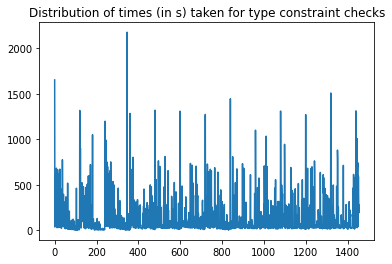

In [95]:
import seaborn as sns
sns.lineplot(data=pd.Series(times)).set_title("Distribution of times (in s) taken for type constraint checks")

## Value Type Constraint

### Understand Constraints File

In [9]:
import pandas as pd
dfValueType = pd.read_csv('../../constraintsOP/valuetypeConstraint/claims.type-constraints_all1.tsv',sep='\t')

In [10]:
dfValueType = dfValueType.groupby(['node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [11]:
dfValueType.head()

,node1,label,node2
0,P1000,P2308,[Q1241356]
1,P1000,P2309,[Q30208840]
2,P1001,P2308,"[Q20926517, Q2881272, Q2882257, Q3624078, Q389..."
3,P1001,P2309,[Q30208840]
4,P1002,P2308,[Q2576663]


In [12]:
dfValueType['label'].unique()

array(['P2308', 'P2309', 'P2303', 'P2316', 'P6607', 'P2304'], dtype=object)

In [13]:
dfValueType[dfValueType['label'] == '2316']

,node1,label,node2


In [14]:
dfValueType[dfValueType['node1'] == 'P1659']

,node1,label,node2
330,P1659,P2308,[Q18616576]
331,P1659,P2309,[Q21503252]
332,P1659,P2316,[Q21502408]


In [15]:
dfValueType[dfValueType.node1 == 'P991']

,node1,label,node2
2031,P991,P2308,"[Q5, Q7210356]"
2032,P991,P2309,[Q21503252]


### Query Generator

In [16]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 1

fOP = None

for prop in tqdm(dfValueType.node1.unique()):
    try:
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
        relation = dfValueType[(dfValueType['node1'] == prop) & (dfValueType['label'] == 'P2309')].node2.values[0][0]
        type1 = dfValueType[(dfValueType['node1'] == prop) & (dfValueType['label'] == 'P2316')].node2.values
#         print(type1)

        parents = dfValueType[(dfValueType['node1'] == prop) & (dfValueType['label'] == 'P2308')].node2.values[0]
        exceptions = dfValueType[(dfValueType['node1'] == prop) & (dfValueType['label'] == 'P2303')].node2.values
        
        if relation == "Q21503252":
            parentFile = "P31"
            parentTitle = 'instanceOf'
        elif relation == "Q21514624":
            parentFile = "P279"
            parentTitle = 'subclass'
        else:
            parentFile = "isa"
            parentTitle = 'instanceOfOrSubclass'

        if len(type1) != 0 and type1[0][0] == "Q21502408":
            typeVal = "mandatory"
        elif len(type1) != 0 and type1[0][0] == "Q62026391":
            typeVal = "suggestion"
        else:
            typeVal = "normal"

        if len(exceptions):
            exceptionPart = "or node2 in " + str(exceptions[0]).replace("'",'"')
        else:
            exceptionPart = ""
        
        folderName = 'valueTypeConstraint'
        shellFileSuffix = 'valueTypeConstraintValidator'
        
        if cnt % 120 == 0:
            if fOP:
                fOP.close()
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
            fCnt += 1
        
        fOP.write("{ time (kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
        ../../wikidata-20210215/derived." + parentFile + ".tsv.gz \
        ../../wikidata-20210215/derived.P279star.tsv.gz \
        --match 'm: (node1)-[nodeProp]->(node2), " + parentFile + ": (node2)-[]->(nodex), P279star: (nodex)-[]->(par)' \
        --where 'par in " + str(parents).replace("'",'"') + " " + exceptionPart + "' \
        --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`' \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        --graph-cache ~/sqlite3_caches/valueType_new213_" + str(fCnt) + ".sqlite3.db; \
         kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
        --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv ;\
        kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv \
        ../../wikidata-20210215/derived." + parentFile + ".tsv.gz \
        --match 'm: (node1)-[nodeProp]->(node2), " + parentFile + ": (node2)-[]->(par)' \
        --where 'par in " + str(parents).replace("'",'"') + " " + exceptionPart + "' \
        --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`' \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        --graph-cache ~/sqlite3_caches/valueType_new213_" + str(fCnt) + ".sqlite3.db; \
         kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv \
        --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect.tsv ; \
         kgtk --debug cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct.tsv ; \
        ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n")

        cnt += 1
    except:
        print("Something failed for prop:",prop)

if fOP:
    fOP.close()

  0%|          | 0/932 [00:00<?, ?it/s]

Something failed for prop: P1389


In [17]:
cnt

904

In [18]:
# import os
# for i in range(1,9):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/valueTypeConstraintValidator"+str(i)+".sh")
    

### Analyze Violations

In [21]:
import pandas as pd
import os
from tqdm.notebook import tqdm

valueTypeConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt

valueTypePropList = set()

violations = {}

for folder in tqdm(iter(['mandatory', 'suggestion', 'normal'])):
    valueTypeConstViolations[folder] = {'instanceOf': {'correct': 0, 'incorrect': 0}, 'subclass': {'correct': 0, 'incorrect': 0}, 'instanceOfOrSubclass': {'correct': 0, 'incorrect': 0}, 'propCount':0}
    filePath = "../../allConstraintsAnalysis_WRemoved_Final/valuetypeConstraint_Final4/"+folder+"/"
    for filename in tqdm(os.listdir(filePath)):
        type1 = filename.split(".")[2]
        prop = filename.split(".")[3]
        valueTypePropList.add(prop)
        correctness = filename.split(".")[4]
        count1 = countLines(filePath+filename)
        valueTypeConstViolations[folder][type1][correctness] += count1
        if prop not in violations:
            violations[prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        violations[prop][correctness] = count1
        violations[prop]['paths'].append(filePath+filename)
        if correctness == 'correct':
            valueTypeConstViolations[folder]['propCount'] += 1
        

0it [00:00, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1572 [00:00<?, ?it/s]

In [22]:
# countLines("../../allConstraintsAnalysis_WRemoved_Final/typeConstraint/mandatory/claims.type-constraints.subclass.P534.incorrect.tsv")

In [23]:
recordCount = 0
for elem in valueTypeConstViolations.keys():
    for key1 in valueTypeConstViolations[elem].keys():
        try:
            recordCount += valueTypeConstViolations[elem][key1]['correct'] + valueTypeConstViolations[elem][key1]['incorrect']
        except:
            continue
print(f"{len(valueTypePropList)} properties processed for value type constraint for {recordCount} statements")

897 properties processed for value type constraint for 181823950 statements


In [24]:
import pandas as pd
valTypeConstDF = pd.DataFrame(violations).T

In [25]:
valTypeConstDF['violation_ratio'] = valTypeConstDF.apply(lambda p: p.incorrect / (p.incorrect + p.correct), axis=1)

In [26]:
valTypeConstDF.head()

,correct,incorrect,paths,violation_ratio
P2302,42211,0,[../../allConstraintsAnalysis/valuetypeConstra...,0.000000
P3092,4620,1,[../../allConstraintsAnalysis/valuetypeConstra...,0.000216
P3096,11150,2,[../../allConstraintsAnalysis/valuetypeConstra...,0.000179
P3156,348,0,[../../allConstraintsAnalysis/valuetypeConstra...,0.000000
P87,4766,3,[../../allConstraintsAnalysis/valuetypeConstra...,0.000629


In [27]:
valTypeConstDF.sort_values(by=['violation_ratio','incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P5008,0,331026,[../../allConstraintsAnalysis/valuetypeConstra...,1.0
P6104,0,9764,[../../allConstraintsAnalysis/valuetypeConstra...,1.0
P2545,0,1369,[../../allConstraintsAnalysis/valuetypeConstra...,1.0
P2668,0,168,[../../allConstraintsAnalysis/valuetypeConstra...,1.0
P7374,0,32,[../../allConstraintsAnalysis/valuetypeConstra...,1.0
P2839,0,14,[../../allConstraintsAnalysis/valuetypeConstra...,1.0
P3028,0,13,[../../allConstraintsAnalysis/valuetypeConstra...,1.0
P3027,0,12,[../../allConstraintsAnalysis/valuetypeConstra...,1.0
P2127,0,11,[../../allConstraintsAnalysis/valuetypeConstra...,1.0
P538,0,10,[../../allConstraintsAnalysis/valuetypeConstra...,1.0


In [2]:
!cat ../../allConstraintsAnalysis_WRemoved_Final/valuetypeConstraint_Final4/normal/claims.type-constraints.instanceOf.P5008.incorrect.tsv

id	node1	label	node2	rank	node2;wikidatatype
P4203-P5008-Q19794158-515f4c63-0	P4203	P5008	Q19794158	normal	wikibase-item
P5588-P5008-Q56241615-f715260d-0	P5588	P5008	Q56241615	normal	wikibase-item
P5626-P5008-Q56241615-b866338e-0	P5626	P5008	Q56241615	normal	wikibase-item
P5698-P5008-Q56241615-1ffb183c-0	P5698	P5008	Q56241615	normal	wikibase-item
P8365-P5008-Q98970039-e9e140e8-0	P8365	P5008	Q98970039	normal	wikibase-item
P8370-P5008-Q98970039-690f8eed-0	P8370	P5008	Q98970039	normal	wikibase-item
P8374-P5008-Q98970039-47e6c1ed-0	P8374	P5008	Q98970039	normal	wikibase-item
P8516-P5008-Q98970039-2def31d7-0	P8516	P5008	Q98970039	normal	wikibase-item
P8539-P5008-Q98970039-66ef67cc-0	P8539	P5008	Q98970039	normal	wikibase-item
P8540-P5008-Q98970039-e1bf5c19-0	P8540	P5008	Q98970039	normal	wikibase-item
P8563-P5008-Q98970039-4ab14d04-0	P8563	P5008	Q98970039	normal	wikibase-item
P8614-P5008-Q98970039-d471aa3e-0	P8614	P5008	Q98970039	normal	wikibase-item
P8629-P5008-Q98970039-e973e3f9-0	P8629	P500

Q101540521-P5008-Q98970039-493ed584-0	Q101540521	P5008	Q98970039	normal	wikibase-item
Q101540627-P5008-Q98970039-d8efd450-0	Q101540627	P5008	Q98970039	normal	wikibase-item
Q101540721-P5008-Q98970039-fc668fa3-0	Q101540721	P5008	Q98970039	normal	wikibase-item
Q101541502-P5008-Q98970039-697485ae-0	Q101541502	P5008	Q98970039	normal	wikibase-item
Q101541816-P5008-Q98970039-9b3b823b-0	Q101541816	P5008	Q98970039	normal	wikibase-item
Q101541861-P5008-Q100137722-3fe1e3d4-0	Q101541861	P5008	Q100137722	normal	wikibase-item
Q101542003-P5008-Q100137722-aeb205c7-0	Q101542003	P5008	Q100137722	normal	wikibase-item
Q101542237-P5008-Q100742996-9ca0358f-0	Q101542237	P5008	Q100742996	normal	wikibase-item
Q101542309-P5008-Q100742996-e7452df1-0	Q101542309	P5008	Q100742996	normal	wikibase-item
Q101542323-P5008-Q100742996-39d8298a-0	Q101542323	P5008	Q100742996	normal	wikibase-item
Q101542324-P5008-Q100742996-45ee5967-0	Q101542324	P5008	Q100742996	normal	wikibase-item
Q101542325-P5008-Q100742996-7a66e102-0	Q10

Q102272687-P5008-Q98970042-36954532-0	Q102272687	P5008	Q98970042	normal	wikibase-item
Q102272688-P5008-Q98970042-c888c6a4-0	Q102272688	P5008	Q98970042	normal	wikibase-item
Q102272690-P5008-Q98970042-05ac4a79-0	Q102272690	P5008	Q98970042	normal	wikibase-item
Q102272764-P5008-Q98970042-fbfdd328-0	Q102272764	P5008	Q98970042	normal	wikibase-item
Q102272765-P5008-Q98970042-f2405b10-0	Q102272765	P5008	Q98970042	normal	wikibase-item
Q102272768-P5008-Q98970042-e8982633-0	Q102272768	P5008	Q98970042	normal	wikibase-item
Q102272770-P5008-Q98970042-ab6669c5-0	Q102272770	P5008	Q98970042	normal	wikibase-item
Q102272888-P5008-Q98970042-033dffb7-0	Q102272888	P5008	Q98970042	normal	wikibase-item
Q102272889-P5008-Q98970042-459ea468-0	Q102272889	P5008	Q98970042	normal	wikibase-item
Q102272890-P5008-Q98970042-5d69d23d-0	Q102272890	P5008	Q98970042	normal	wikibase-item
Q102272892-P5008-Q98970042-5478f6db-0	Q102272892	P5008	Q98970042	normal	wikibase-item
Q102272893-P5008-Q98970042-dcda86d9-0	Q102272893	P5008

Q102713184-P5008-Q98970042-da3f63b0-0	Q102713184	P5008	Q98970042	normal	wikibase-item
Q102713189-P5008-Q98970042-d1c17742-0	Q102713189	P5008	Q98970042	normal	wikibase-item
Q102713193-P5008-Q98970042-4c769543-0	Q102713193	P5008	Q98970042	normal	wikibase-item
Q102713196-P5008-Q98970042-66b79039-0	Q102713196	P5008	Q98970042	normal	wikibase-item
Q102713205-P5008-Q98970042-e0bfcd03-0	Q102713205	P5008	Q98970042	normal	wikibase-item
Q10272063-P5008-Q98099248-2aa47147-0	Q10272063	P5008	Q98099248	normal	wikibase-item
Q102725979-P5008-Q98970042-d1aedde6-0	Q102725979	P5008	Q98970042	normal	wikibase-item
Q102725982-P5008-Q98970042-c8e1efbe-0	Q102725982	P5008	Q98970042	normal	wikibase-item
Q102725987-P5008-Q98970042-2971cb73-0	Q102725987	P5008	Q98970042	normal	wikibase-item
Q102725990-P5008-Q98970042-2b0a2f89-0	Q102725990	P5008	Q98970042	normal	wikibase-item
Q102725996-P5008-Q98970042-7112efb7-0	Q102725996	P5008	Q98970042	normal	wikibase-item
Q102725998-P5008-Q98970042-c9b16552-0	Q102725998	P5008	Q

Q1130724-P5008-Q24909800-c688c985-0	Q1130724	P5008	Q24909800	normal	wikibase-item
Q113081-P5008-Q69524601-09fbb4f4-0	Q113081	P5008	Q69524601	normal	wikibase-item
Q11309346-P5008-Q24909800-6d1ce6c3-0	Q11309346	P5008	Q24909800	normal	wikibase-item
Q113099-P5008-Q24909800-56f3854d-0	Q113099	P5008	Q24909800	normal	wikibase-item
Q1130994-P5008-Q66098665-219dd30d-0	Q1130994	P5008	Q66098665	normal	wikibase-item
Q1131001-P5008-Q66098665-54ecca73-0	Q1131001	P5008	Q66098665	normal	wikibase-item
Q1131042-P5008-Q66098665-c95f2fc7-0	Q1131042	P5008	Q66098665	normal	wikibase-item
Q1131043-P5008-Q66098665-6472527b-0	Q1131043	P5008	Q66098665	normal	wikibase-item
Q1131048-P5008-Q66098665-3fcb19c7-0	Q1131048	P5008	Q66098665	normal	wikibase-item
Q1131051-P5008-Q66098665-aa8bdf22-0	Q1131051	P5008	Q66098665	normal	wikibase-item
Q1131053-P5008-Q66098665-19525f92-0	Q1131053	P5008	Q66098665	normal	wikibase-item
Q1131054-P5008-Q66098665-d584f70f-0	Q1131054	P5008	Q66098665	normal	wikibase-item
Q1131059-P5008-Q66

Q13481376-P5008-Q66098665-5d3e484c-0	Q13481376	P5008	Q66098665	normal	wikibase-item
Q13481386-P5008-Q66098665-0e877073-0	Q13481386	P5008	Q66098665	normal	wikibase-item
Q13481396-P5008-Q66098665-9d5efc90-0	Q13481396	P5008	Q66098665	normal	wikibase-item
Q134814-P5008-Q56810037-36d8561d-0	Q134814	P5008	Q56810037	normal	wikibase-item
Q13481407-P5008-Q66098665-0686e9eb-0	Q13481407	P5008	Q66098665	normal	wikibase-item
Q13481418-P5008-Q66098665-933baff3-0	Q13481418	P5008	Q66098665	normal	wikibase-item
Q13481434-P5008-Q66098665-50b48173-0	Q13481434	P5008	Q66098665	normal	wikibase-item
Q13481443-P5008-Q66098665-7f6b4c0b-0	Q13481443	P5008	Q66098665	normal	wikibase-item
Q13481452-P5008-Q66098665-76ca390b-0	Q13481452	P5008	Q66098665	normal	wikibase-item
Q13481465-P5008-Q66098665-21623b5a-0	Q13481465	P5008	Q66098665	normal	wikibase-item
Q13481477-P5008-Q66098665-8255ef33-0	Q13481477	P5008	Q66098665	normal	wikibase-item
Q13481488-P5008-Q66098665-0af9cf10-0	Q13481488	P5008	Q66098665	normal	wikibase-i

Q14622591-P5008-Q66098665-de835be1-0	Q14622591	P5008	Q66098665	normal	wikibase-item
Q146227-P5008-Q85931561-b0c33258-0	Q146227	P5008	Q85931561	normal	wikibase-item
Q1462309-P5008-Q4099686-eccd74bd-0	Q1462309	P5008	Q4099686	normal	wikibase-item
Q1462317-P5008-Q66098665-9f28b361-0	Q1462317	P5008	Q66098665	normal	wikibase-item
Q1462321-P5008-Q66098665-9741b1aa-0	Q1462321	P5008	Q66098665	normal	wikibase-item
Q14623252-P5008-Q15304953-aa5f6bc0-0	Q14623252	P5008	Q15304953	normal	wikibase-item
Q146238-P5008-Q13382529-75c708b7-0	Q146238	P5008	Q13382529	normal	wikibase-item
Q1462491-P5008-Q66098665-7df38a8a-0	Q1462491	P5008	Q66098665	normal	wikibase-item
Q14624995-P5008-Q66098665-e7f19ca7-0	Q14624995	P5008	Q66098665	normal	wikibase-item
Q14624996-P5008-Q66098665-76849756-0	Q14624996	P5008	Q66098665	normal	wikibase-item
Q14624997-P5008-Q66098665-8ea02274-0	Q14624997	P5008	Q66098665	normal	wikibase-item
Q14624998-P5008-Q66098665-1c415b37-0	Q14624998	P5008	Q66098665	normal	wikibase-item
Q14624999-

Q16014336-P5008-Q15304953-d8bc3c8f-0	Q16014336	P5008	Q15304953	normal	wikibase-item
Q16014458-P5008-Q24909800-1a6f8138-0	Q16014458	P5008	Q24909800	normal	wikibase-item
Q160145-P5008-Q69524601-83ca50b4-0	Q160145	P5008	Q69524601	normal	wikibase-item
Q16014543-P5008-Q98755339-2959c8c8-0	Q16014543	P5008	Q98755339	normal	wikibase-item
Q16014545-P5008-Q15304953-a0ca2c5a-0	Q16014545	P5008	Q15304953	normal	wikibase-item
Q16014741-P5008-Q55322495-43a18d4b-0	Q16014741	P5008	Q55322495	normal	wikibase-item
Q16014899-P5008-Q15304953-96ac029e-0	Q16014899	P5008	Q15304953	normal	wikibase-item
Q16014908-P5008-Q15304953-e9b548d3-0	Q16014908	P5008	Q15304953	normal	wikibase-item
Q16015073-P5008-Q24909800-a2e2c6eb-0	Q16015073	P5008	Q24909800	normal	wikibase-item
Q16015125-P5008-Q15304953-6ec918d0-0	Q16015125	P5008	Q15304953	normal	wikibase-item
Q160152-P5008-Q13382529-d6bd3729-0	Q160152	P5008	Q13382529	normal	wikibase-item
Q16015205-P5008-Q13382529-d1e8fdb4-0	Q16015205	P5008	Q13382529	normal	wikibase-item


Q17144153-P5008-Q4099686-ba4390f6-0	Q17144153	P5008	Q4099686	normal	wikibase-item
Q17144188-P5008-Q4099686-6c3ed66a-0	Q17144188	P5008	Q4099686	normal	wikibase-item
Q17144217-P5008-Q4099686-45ab9752-0	Q17144217	P5008	Q4099686	normal	wikibase-item
Q17144221-P5008-Q13382529-189871e5-0	Q17144221	P5008	Q13382529	normal	wikibase-item
Q17144348-P5008-Q15304953-30f6c004-0	Q17144348	P5008	Q15304953	normal	wikibase-item
Q17145464-P5008-Q24909800-f061d76a-0	Q17145464	P5008	Q24909800	normal	wikibase-item
Q17145506-P5008-Q67147253-6ab5569b-0	Q17145506	P5008	Q67147253	normal	wikibase-item
Q17145626-P5008-Q4099686-1e491efe-0	Q17145626	P5008	Q4099686	normal	wikibase-item
Q17146000-P5008-Q4099686-0b73c49e-0	Q17146000	P5008	Q4099686	normal	wikibase-item
Q17146028-P5008-Q24909800-02f7126e-0	Q17146028	P5008	Q24909800	normal	wikibase-item
Q17146304-P5008-Q13382529-4e5502a0-0	Q17146304	P5008	Q13382529	normal	wikibase-item
Q17146579-P5008-Q87748614-273bef80-0	Q17146579	P5008	Q87748614	normal	wikibase-item
Q1

Q18554164-P5008-Q4099686-4d944963-0	Q18554164	P5008	Q4099686	normal	wikibase-item
Q18554169-P5008-Q4099686-18e060f3-0	Q18554169	P5008	Q4099686	normal	wikibase-item
Q18554170-P5008-Q4099686-9f0a541a-0	Q18554170	P5008	Q4099686	normal	wikibase-item
Q18554171-P5008-Q4099686-f22c41b5-0	Q18554171	P5008	Q4099686	normal	wikibase-item
Q18554172-P5008-Q4099686-2918cd03-0	Q18554172	P5008	Q4099686	normal	wikibase-item
Q18554173-P5008-Q4099686-0a8877ca-0	Q18554173	P5008	Q4099686	normal	wikibase-item
Q18554175-P5008-Q4099686-e725c249-0	Q18554175	P5008	Q4099686	normal	wikibase-item
Q18554178-P5008-Q4099686-d5228856-0	Q18554178	P5008	Q4099686	normal	wikibase-item
Q18554179-P5008-Q4099686-76eba248-0	Q18554179	P5008	Q4099686	normal	wikibase-item
Q18554180-P5008-Q4099686-e1a5352d-0	Q18554180	P5008	Q4099686	normal	wikibase-item
Q18554181-P5008-Q4099686-c57c400a-0	Q18554181	P5008	Q4099686	normal	wikibase-item
Q18554182-P5008-Q4099686-192b4377-0	Q18554182	P5008	Q4099686	normal	wikibase-item
Q18554183-P5008-

Q18557709-P5008-Q4099686-ed74e6c4-0	Q18557709	P5008	Q4099686	normal	wikibase-item
Q18557710-P5008-Q4099686-b30a9039-0	Q18557710	P5008	Q4099686	normal	wikibase-item
Q18557711-P5008-Q4099686-4511cc74-0	Q18557711	P5008	Q4099686	normal	wikibase-item
Q18557712-P5008-Q4099686-54e1da7d-0	Q18557712	P5008	Q4099686	normal	wikibase-item
Q18557713-P5008-Q4099686-6103b78c-0	Q18557713	P5008	Q4099686	normal	wikibase-item
Q18557715-P5008-Q4099686-ebeb7a9b-0	Q18557715	P5008	Q4099686	normal	wikibase-item
Q18557716-P5008-Q4099686-20ac3799-0	Q18557716	P5008	Q4099686	normal	wikibase-item
Q18557717-P5008-Q4099686-1d8bd23b-0	Q18557717	P5008	Q4099686	normal	wikibase-item
Q18557718-P5008-Q4099686-005da249-0	Q18557718	P5008	Q4099686	normal	wikibase-item
Q18557721-P5008-Q4099686-9c9c4fe0-0	Q18557721	P5008	Q4099686	normal	wikibase-item
Q18557722-P5008-Q4099686-e77926c0-0	Q18557722	P5008	Q4099686	normal	wikibase-item
Q18557723-P5008-Q4099686-a97972f0-0	Q18557723	P5008	Q4099686	normal	wikibase-item
Q18557724-P5008-

Q18975271-P5008-Q4099686-ba416894-0	Q18975271	P5008	Q4099686	normal	wikibase-item
Q18975272-P5008-Q4099686-33f3487b-0	Q18975272	P5008	Q4099686	normal	wikibase-item
Q18975275-P5008-Q4099686-2b627cde-0	Q18975275	P5008	Q4099686	normal	wikibase-item
Q18975283-P5008-Q4099686-28992c3f-0	Q18975283	P5008	Q4099686	normal	wikibase-item
Q18975290-P5008-Q4099686-4ac0a568-0	Q18975290	P5008	Q4099686	normal	wikibase-item
Q18975291-P5008-Q4099686-066b7d90-0	Q18975291	P5008	Q4099686	normal	wikibase-item
Q18975292-P5008-Q4099686-c49b19cb-0	Q18975292	P5008	Q4099686	normal	wikibase-item
Q18975304-P5008-Q4099686-4cbef1ce-0	Q18975304	P5008	Q4099686	normal	wikibase-item
Q18975309-P5008-Q4099686-d1abac72-0	Q18975309	P5008	Q4099686	normal	wikibase-item
Q18975311-P5008-Q4099686-4fbb96cc-0	Q18975311	P5008	Q4099686	normal	wikibase-item
Q18975321-P5008-Q4099686-3868a186-0	Q18975321	P5008	Q4099686	normal	wikibase-item
Q18975322-P5008-Q4099686-6b5256f0-0	Q18975322	P5008	Q4099686	normal	wikibase-item
Q18975323-P5008-

Q19754738-P5008-Q60687720-a5ebf637-0	Q19754738	P5008	Q60687720	normal	wikibase-item
Q19754757-P5008-Q58468254-f9f7eb91-0	Q19754757	P5008	Q58468254	normal	wikibase-item
Q19754757-P5008-Q60687720-3583c414-0	Q19754757	P5008	Q60687720	normal	wikibase-item
Q19754950-P5008-Q60687720-6fb304e4-0	Q19754950	P5008	Q60687720	normal	wikibase-item
Q19755067-P5008-Q60687720-4b4dea43-0	Q19755067	P5008	Q60687720	normal	wikibase-item
Q19755816-P5008-Q58468254-dd881b87-0	Q19755816	P5008	Q58468254	normal	wikibase-item
Q19756134-P5008-Q58468254-14de060f-0	Q19756134	P5008	Q58468254	normal	wikibase-item
Q19756268-P5008-Q60687720-09ddab20-0	Q19756268	P5008	Q60687720	normal	wikibase-item
Q19756283-P5008-Q24909800-fe7faa55-0	Q19756283	P5008	Q24909800	normal	wikibase-item
Q19757448-P5008-Q15304953-2ae1e558-0	Q19757448	P5008	Q15304953	normal	wikibase-item
Q19757448-P5008-Q94124522-43a9ad4f-0	Q19757448	P5008	Q94124522	normal	wikibase-item
Q19757452-P5008-Q15304953-00f70009-0	Q19757452	P5008	Q15304953	normal	wikiba

Q21066276-P5008-Q15304953-9ad1199f-0	Q21066276	P5008	Q15304953	normal	wikibase-item
Q21066633-P5008-Q60687720-7609a6de-0	Q21066633	P5008	Q60687720	normal	wikibase-item
Q21066669-P5008-Q67147253-00ebe6d4-0	Q21066669	P5008	Q67147253	normal	wikibase-item
Q21066680-P5008-Q67147253-6bb6cf2c-0	Q21066680	P5008	Q67147253	normal	wikibase-item
Q21066907-P5008-Q24909800-84f86a34-0	Q21066907	P5008	Q24909800	normal	wikibase-item
Q21067123-P5008-Q24909800-47217e36-0	Q21067123	P5008	Q24909800	normal	wikibase-item
Q21067173-P5008-Q24909800-769a6d24-0	Q21067173	P5008	Q24909800	normal	wikibase-item
Q21067341-P5008-Q60687720-5de8e5fb-0	Q21067341	P5008	Q60687720	normal	wikibase-item
Q21067868-P5008-Q24909800-f121ef1c-0	Q21067868	P5008	Q24909800	normal	wikibase-item
Q21068012-P5008-Q13382529-26743090-0	Q21068012	P5008	Q13382529	normal	wikibase-item
Q21068012-P5008-Q15304953-4f8a01fa-0	Q21068012	P5008	Q15304953	normal	wikibase-item
Q21068127-P5008-Q13382529-e566c74c-0	Q21068127	P5008	Q13382529	normal	wikiba

Q21972895-P5008-Q85931561-0bf6acb4-0	Q21972895	P5008	Q85931561	normal	wikibase-item
Q21972896-P5008-Q85931561-af3b374a-0	Q21972896	P5008	Q85931561	normal	wikibase-item
Q21972897-P5008-Q85931561-5120b837-0	Q21972897	P5008	Q85931561	normal	wikibase-item
Q21972898-P5008-Q85931561-d357c7f0-0	Q21972898	P5008	Q85931561	normal	wikibase-item
Q21972899-P5008-Q85931561-bcd623f8-0	Q21972899	P5008	Q85931561	normal	wikibase-item
Q21972900-P5008-Q85931561-4aaec71d-0	Q21972900	P5008	Q85931561	normal	wikibase-item
Q21972901-P5008-Q85931561-1b4e1957-0	Q21972901	P5008	Q85931561	normal	wikibase-item
Q21972902-P5008-Q85931561-8b9c3894-0	Q21972902	P5008	Q85931561	normal	wikibase-item
Q21972903-P5008-Q85931561-20ee0fc7-0	Q21972903	P5008	Q85931561	normal	wikibase-item
Q21972904-P5008-Q85931561-0f048aaf-0	Q21972904	P5008	Q85931561	normal	wikibase-item
Q21972905-P5008-Q85931561-e45a7e83-0	Q21972905	P5008	Q85931561	normal	wikibase-item
Q21972906-P5008-Q85931561-4a460870-0	Q21972906	P5008	Q85931561	normal	wikiba

Q2376219-P5008-Q4099686-f20e53af-0	Q2376219	P5008	Q4099686	normal	wikibase-item
Q23762327-P5008-Q15304953-7a20f7b8-0	Q23762327	P5008	Q15304953	normal	wikibase-item
Q23762449-P5008-Q63845230-8ba8aab3-0	Q23762449	P5008	Q63845230	normal	wikibase-item
Q23762552-P5008-Q15304953-51d9bc9a-0	Q23762552	P5008	Q15304953	normal	wikibase-item
Q2376264-P5008-Q4099686-8b35308b-0	Q2376264	P5008	Q4099686	normal	wikibase-item
Q23762774-P5008-Q24909800-348d3eb2-0	Q23762774	P5008	Q24909800	normal	wikibase-item
Q237633-P5008-Q15304953-16127fd7-0	Q237633	P5008	Q15304953	normal	wikibase-item
Q23763787-P5008-Q54439832-27daae7a-0	Q23763787	P5008	Q54439832	normal	wikibase-item
Q2376389-P5008-Q66098665-669ef6bc-0	Q2376389	P5008	Q66098665	normal	wikibase-item
Q2376397-P5008-Q66098665-8a5cf7ed-0	Q2376397	P5008	Q66098665	normal	wikibase-item
Q237651-P5008-Q60687720-8ffddf2a-0	Q237651	P5008	Q60687720	normal	wikibase-item
Q2376518-P5008-Q4099686-ada03541-0	Q2376518	P5008	Q4099686	normal	wikibase-item
Q23765425-P5008-

Q24632447-P5008-Q55439927-95ee35d3-0	Q24632447	P5008	Q55439927	normal	wikibase-item
Q24632524-P5008-Q55439927-c0544213-0	Q24632524	P5008	Q55439927	normal	wikibase-item
Q24632533-P5008-Q55439927-156a7ec8-0	Q24632533	P5008	Q55439927	normal	wikibase-item
Q24632655-P5008-Q55439927-5399b36c-0	Q24632655	P5008	Q55439927	normal	wikibase-item
Q24632764-P5008-Q55439927-c541b6c4-0	Q24632764	P5008	Q55439927	normal	wikibase-item
Q24633044-P5008-Q55439927-0b99e411-0	Q24633044	P5008	Q55439927	normal	wikibase-item
Q24633070-P5008-Q55439927-5f97f264-0	Q24633070	P5008	Q55439927	normal	wikibase-item
Q24633113-P5008-Q55439927-6f1314bb-0	Q24633113	P5008	Q55439927	normal	wikibase-item
Q24633277-P5008-Q55439927-16a54dd3-0	Q24633277	P5008	Q55439927	normal	wikibase-item
Q24633298-P5008-Q56241615-3ce317be-0	Q24633298	P5008	Q56241615	normal	wikibase-item
Q24633486-P5008-Q55439927-17dab102-0	Q24633486	P5008	Q55439927	normal	wikibase-item
Q24633526-P5008-Q55439927-f84031f6-0	Q24633526	P5008	Q55439927	normal	wikiba

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
valTypeConstDF['violation_ratio'].describe()

count    897.000000
mean       0.083622
std        0.205759
min        0.000000
25%        0.000451
50%        0.006186
75%        0.042042
max        1.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Value Type Constraint Violation Ratios')

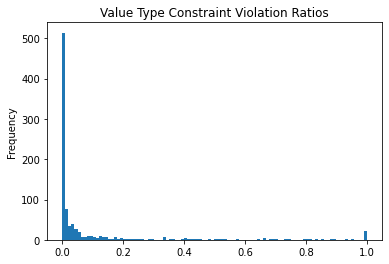

In [29]:
valTypeConstDF['violation_ratio'].plot.hist(bins=100).set_title("Value Type Constraint Violation Ratios")

Text(0.5, 1.0, 'Value Type Constraint Violation Ratios (<=0.04)')

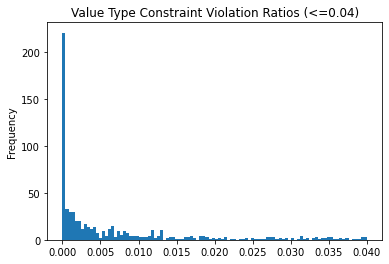

In [30]:
valTypeConstDF[valTypeConstDF['violation_ratio'] <= 0.04].violation_ratio.plot.hist(bins=100).set_title("Value Type Constraint Violation Ratios (<=0.04)")

In [31]:
print(f"No. of constraints whose violation ratio is greater than mean :{sum(valTypeConstDF['violation_ratio'] >= 3.950680)}/{len(valTypeConstDF)}")

No. of constraints whose violation ratio is greater than mean :0/897


In [32]:
# valTypeConstDF.sort_values(by=['violation_ratio'],ascending=False).head().paths.values

In [33]:
# !head ../../allConstraintsAnalysis_WRemoved_Final/typeConstraint/normal/claims.type-constraints.instanceOf.P7535.incorrect.tsv

In [34]:
for key1 in valueTypeConstViolations.keys():
    valueTypeConstViolations[key1]['correct'] = valueTypeConstViolations[key1]['instanceOf']['correct'] + valueTypeConstViolations[key1]['subclass']['correct'] + valueTypeConstViolations[key1]['instanceOfOrSubclass']['correct']
    valueTypeConstViolations[key1]['incorrect'] = valueTypeConstViolations[key1]['instanceOf']['incorrect'] + valueTypeConstViolations[key1]['subclass']['incorrect'] + valueTypeConstViolations[key1]['instanceOfOrSubclass']['incorrect']
    valueTypeConstViolations[key1]['VR'] = valueTypeConstViolations[key1]['incorrect'] / (valueTypeConstViolations[key1]['correct'] + valueTypeConstViolations[key1]['incorrect'])
        

In [35]:
valueTypeConstViolations

{'mandatory': {'instanceOf': {'correct': 11391695, 'incorrect': 3339},
  'subclass': {'correct': 44764, 'incorrect': 1},
  'instanceOfOrSubclass': {'correct': 11638, 'incorrect': 35},
  'propCount': 106,
  'correct': 11448097,
  'incorrect': 3375,
  'VR': 0.00029472193618427394},
 'suggestion': {'instanceOf': {'correct': 46036, 'incorrect': 474},
  'subclass': {'correct': 118, 'incorrect': 18},
  'instanceOfOrSubclass': {'correct': 0, 'incorrect': 0},
  'propCount': 5,
  'correct': 46154,
  'incorrect': 492,
  'VR': 0.01054752819105604},
 'normal': {'instanceOf': {'correct': 88858176, 'incorrect': 689971},
  'subclass': {'correct': 4373665, 'incorrect': 6190},
  'instanceOfOrSubclass': {'correct': 76234047, 'incorrect': 163783},
  'propCount': 786,
  'correct': 169465888,
  'incorrect': 859944,
  'VR': 0.00504881725750208}}

In [36]:
valTypeConstDF.to_csv('../../allConstraintsAnalysis_WRemoved_Final/valueTypeConstDFAnalysis.csv')

### Find out time required

In [35]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
filePath = '/data/wd-correctness/propertiesSplit_WRemoved_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("valueTypeConstraintValidator_xverify3"):
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes

  0%|          | 0/313 [00:00<?, ?it/s]

In [79]:
print(pd.Series(times).describe())

count     897.000000
mean       41.756467
std       133.639231
min         1.516000
25%         3.236000
50%         6.851000
75%        24.280000
max      1683.328000
dtype: float64


Text(0.5, 1.0, 'Distribution of times (in s) taken for value type constraint checks')

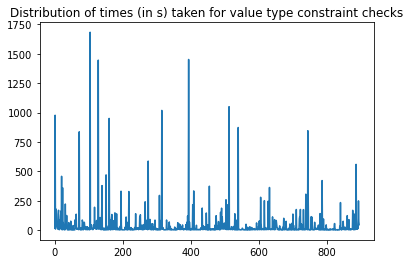

In [80]:
import seaborn as sns
sns.lineplot(data=pd.Series(times)).set_title("Distribution of times (in s) taken for value type constraint checks")

## Item Requires Statement Constraint

### Understand Constraints File

In [13]:
import pandas as pd
import math
dfItemRequires = pd.read_csv('../../constraintsOP/itemRequiresConstraint/claims.type-constraints_all.tsv',sep='\t')

In [14]:
dfItemRequires = dfItemRequires.groupby(['id','node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [15]:
dfItemRequires['label'].unique()

array(['P2306', 'P2305', 'P2316', 'P2304', 'P2303', 'P6607', 'P4155',
       'P31', 'P2916', 'P4680', 'P2308'], dtype=object)

In [16]:
dfItemRequires['label'].value_counts()

P2306    7182
P2305    2540
P2316    2523
P2303     422
P6607      14
P2304      14
P2916       5
P4680       2
P4155       1
P31         1
P2308       1
Name: label, dtype: int64

In [17]:
#Reference: https://stackoverflow.com/a/17298454
# dfItemRequires.pivot_table('node2', ['node1', 'id'], 'label')
dfItemRequires = dfItemRequires.pivot(index=['node1','id'], columns='label', values='node2')

In [18]:
dfItemRequires.head()

label                                  P2303 P2304   P2305   P2306 P2308  \
node1 id                                                                   
P1006 P1006-P2302-Q21503247-0451ef47-0   NaN   NaN     NaN  [P214]   NaN   
P1010 P1010-P2302-Q21503247-56183614-0   NaN   NaN     NaN   [P31]   NaN   
      P1010-P2302-Q21503247-fd256eaf-0   NaN   NaN  [Q794]   [P17]   NaN   
P1015 P1015-P2302-Q21503247-20e3bfc5-0   NaN   NaN     NaN   [P31]   NaN   
P1017 P1017-P2302-Q21503247-bbac2ce3-0   NaN   NaN     NaN  [P214]   NaN   

label                                         P2316 P2916  P31 P4155 P4680  \
node1 id                                                                     
P1006 P1006-P2302-Q21503247-0451ef47-0          NaN   NaN  NaN   NaN   NaN   
P1010 P1010-P2302-Q21503247-56183614-0          NaN   NaN  NaN   NaN   NaN   
      P1010-P2302-Q21503247-fd256eaf-0  [Q21502408]   NaN  NaN   NaN   NaN   
P1015 P1015-P2302-Q21503247-20e3bfc5-0          NaN   NaN  NaN   NaN   NaN   
P1017 P1017-P2302-Q21503247-bbac2ce3-0          NaN   NaN  NaN   NaN   NaN   

label                                  P6607  
node1 id                                      
P1006 P1006-P2302-Q21503247-0451ef47-0   NaN  
P1010 P1010-P2302-Q21503247-56183614-0   NaN  
      P1010-P2302-Q21503247-fd256eaf-0   NaN  
P1015 P1015-P2302-Q21503247-20e3bfc5-0   NaN  
P1017 P1017-P2302-Q21503247-bbac2ce3-0   NaN

In [19]:
dfItemRequires = dfItemRequires.droplevel(1)

In [20]:
dfItemRequires.head()

label,P2303,P2304,P2305,P2306,P2308,P2316,P2916,P31,P4155,P4680,P6607
node1,,,,,,,,,,,
P1006,NaN,NaN,NaN,[P214],NaN,NaN,NaN,NaN,NaN,NaN,NaN
P1010,NaN,NaN,NaN,[P31],NaN,NaN,NaN,NaN,NaN,NaN,NaN
P1010,NaN,NaN,[Q794],[P17],NaN,[Q21502408],NaN,NaN,NaN,NaN,NaN
P1015,NaN,NaN,NaN,[P31],NaN,NaN,NaN,NaN,NaN,NaN,NaN
P1017,NaN,NaN,NaN,[P214],NaN,NaN,NaN,NaN,NaN,NaN,NaN


However, there is one anomaly where the property does not have a co-dependency constraint associated with it, but still has a link to this constraint.

In [21]:
dfItemRequires[dfItemRequires['P4680'].apply(lambda p: type(p) == list)]

label,P2303,P2304,P2305,P2306,P2308,P2316,P2916,P31,P4155,P4680,P6607
node1,,,,,,,,,,,
P5447,NaN,NaN,[Q55426051],[P5446],NaN,NaN,NaN,NaN,NaN,[Q46466783],NaN
P5448,NaN,NaN,[Q55426051],[P5446],NaN,NaN,NaN,NaN,NaN,[Q46466783],NaN


In [22]:
dfItemRequires[dfItemRequires['P2305'].apply(lambda p: type(p) == list)]

label,P2303,P2304,P2305,P2306,P2308,P2316,P2916,P31,P4155,P4680,P6607
node1,,,,,,,,,,,
P1010,NaN,NaN,[Q794],[P17],NaN,[Q21502408],NaN,NaN,NaN,NaN,NaN
P1045,NaN,NaN,"[Q20808382, Q28218485, Q3044918]",[P39],NaN,NaN,NaN,NaN,NaN,NaN,NaN
P1045,NaN,NaN,[Q82955],[P106],NaN,NaN,NaN,NaN,NaN,NaN,NaN
P1045,NaN,NaN,[Q5],[P31],NaN,[Q21502408],NaN,NaN,NaN,NaN,NaN
P1045,NaN,NaN,"[Q142, Q71084]",[P27],NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
P980,NaN,NaN,[Q34],[P17],NaN,[Q21502408],NaN,NaN,NaN,NaN,NaN
P981,NaN,NaN,[Q55],[P17],NaN,[Q21502408],NaN,NaN,NaN,NaN,NaN
P981,NaN,NaN,[Q1852859],[P31],NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Query Generator

#### Version 1 - Mandatory + Suggestion + Normal

In [11]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

fOP = None

folderName = 'codependencyConstraint'
subFolderName = "Mand_Sugg_Normal"
shellFileSuffix = 'codepConst_MSN_Validator'
graph_cache_file_prefix = "cache_new_11_"

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = mandatory + suggestion + normal
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_WRemoved_Final/claims.P345.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2604.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2355.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P3350.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1014.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2636.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1771.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2755.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P8326.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P5128.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1627.tsv does not exist
File: ../../propertiesSpli

In [12]:
cnt

534

In [13]:
fCnt

9

In [14]:
# from tqdm.notebook import tqdm
# import os.path
# import os
# folderName = 'codependencyConstraint'
# for prop in tqdm(dfItemRequires.index.unique()):
#     for subFolderName in ['Mand_Sugg_Normal', 'Mand_Normal', 'Mand', 'Normal']:
#         if os.path.isfile("../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv") and \
#             os.path.isfile("../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv"):
#                 os.system("kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
#                     ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
#                     -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_w_exceptions.tsv")

In [54]:
# import os
# for i in range(1,28):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/codepConst_MSN_Validator"+str(i)+".sh")

#### Version 2 - Mandatory + Normal

In [15]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

fOP = None

folderName = 'codependencyConstraint'
subFolderName = "Mand_Normal"
shellFileSuffix = 'codepConst_MN_Validator'
graph_cache_file_prefix = "cache_new_22_"

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = mandatory + normal
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_WRemoved_Final/claims.P345.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2604.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2355.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1014.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2636.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1771.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2755.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P8326.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1627.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P954.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P498.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1297.tsv does not exist
File: ../../propertiesSplit_

In [16]:
cnt

475

In [55]:
# import os
# for i in range(1,25):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/codepConst_MN_Validator"+str(i)+".sh")

#### Version 3 - Mandatory

In [17]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

folderName = 'codependencyConstraint'
subFolderName = "Mand"
shellFileSuffix = 'codepConst_M_Validator'
graph_cache_file_prefix = "cache_33_new_"

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = mandatory
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_WRemoved_Final/claims.P1627.tsv does not exist


In [18]:
cnt

79

In [56]:
# import os
# for i in range(1,5):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/codepConst_M_Validator"+str(i)+".sh")

#### Version 4 - Normal

In [21]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

fOP = None

folderName = 'codependencyConstraint'
subFolderName = "Normal"
shellFileSuffix = 'codepConst_N_Validator'
graph_cache_file_prefix = "cache_44_new_"

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = normal
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv\
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_WRemoved_Final/claims.P345.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2604.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2355.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1014.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2636.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1771.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2755.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P8326.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P954.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P498.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1297.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P8680.tsv does not exist
File: ../../propertiesSplit_

In [22]:
cnt

424

In [57]:
# import os
# for i in range(1,23):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/codepConst_N_Validator"+str(i)+".sh")

#### Version 5 - Suggestion

In [23]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

folderName = 'codependencyConstraint'
subFolderName = "Suggestion"
shellFileSuffix = 'codepConst_S_Validator'
graph_cache_file_prefix = "codep_new_66_1_"

fOP = None

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = suggestion
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P3350.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P5128.tsv does not exist


In [24]:
cnt

97

In [58]:
# import os
# for i in range(1,6):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/codepConst_S_Validator"+str(i)+".sh")

### Analyze Violations

In [23]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt

codepConstViolations = {}
codepConstPropList = set()

# codepConstViolationsSummary = {}

for folder in tqdm(iter(['Mand_Sugg_Normal', 'Mand_Normal', 'Mand', 'Normal','Suggestion'])):
    filePath = "../../allConstraintsAnalysis_WRemoved_Final/codependencyConstraint/"+folder+"/"
    for filename in tqdm(os.listdir(filePath)):
        prop = filename.split(".")[1]
        correctness = filename.split(".")[2]
        if correctness not in ['correct','incorrect']:
            continue
        codepConstPropList.add(prop)
        count1 = countLines(filePath+filename)
        if folder not in codepConstViolations:
            codepConstViolations[folder] = {}
        if prop not in codepConstViolations[folder]:
            codepConstViolations[folder][prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        codepConstViolations[folder][prop][correctness] = count1
        codepConstViolations[folder][prop]['paths'].append(filePath+filename)
        
#         if folder not in codepConstViolationsSummary:
#             codepConstViolationsSummary[folder] = {'correct': 0, 'incorrect': 0}
#         codepConstViolationsSummary[folder][correctness] += count1

0it [00:00, ?it/s]

  0%|          | 0/1206 [00:00<?, ?it/s]

  0%|          | 0/1067 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

In [24]:
codepConstViolationsSummary = {}
for folder in codepConstViolations.keys():
    for prop in codepConstViolations[folder].keys():
        if folder not in codepConstViolationsSummary:
            codepConstViolationsSummary[folder] = {'correct': 0, 'incorrect': 0, 'propCount': 0}
        codepConstViolationsSummary[folder]['correct'] += codepConstViolations[folder][prop]['correct']
        codepConstViolationsSummary[folder]['incorrect'] += codepConstViolations[folder][prop]['incorrect']
        codepConstViolationsSummary[folder]['propCount'] += 1

In [25]:
for elem in codepConstViolationsSummary.keys():
    codepConstViolationsSummary[elem]['total'] = codepConstViolationsSummary[elem]['correct'] + codepConstViolationsSummary[elem]['incorrect']
    codepConstViolationsSummary[elem]['percIncorrect'] = codepConstViolationsSummary[elem]['incorrect'] / codepConstViolationsSummary[elem]['total'] * 100

In [26]:
codepConstViolationsSummary

{'Mand_Sugg_Normal': {'correct': 308616510,
  'incorrect': 4841535,
  'propCount': 534,
  'total': 313458045,
  'percIncorrect': 1.5445559867509542},
 'Mand_Normal': {'correct': 278310708,
  'incorrect': 2445456,
  'propCount': 475,
  'total': 280756164,
  'percIncorrect': 0.871024865548455},
 'Mand': {'correct': 5257741,
  'incorrect': 5434,
  'propCount': 79,
  'total': 5263175,
  'percIncorrect': 0.10324566445159053},
 'Normal': {'correct': 277367943,
  'incorrect': 2440290,
  'propCount': 424,
  'total': 279808233,
  'percIncorrect': 0.8721294487428467},
 'Suggestion': {'correct': 31544215,
  'incorrect': 2430724,
  'propCount': 97,
  'total': 33974939,
  'percIncorrect': 7.154461704846622}}

In [27]:
mandatoryPropCount = 0
suggestionPropCount = 0
normalPropCount = 0
for prop in tqdm(dfItemRequires.index.unique()):
    if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
        continue
    prop = str(prop)
    hasMandatory = False
    hasSuggestion = False
    hasNormal = False

    for _, constraint in dfItemRequires.loc[[prop]].iterrows():
        prop2 = constraint['P2306']
            
        if type(prop2) != list:
            continue
        prop2 = prop2[0]

        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
            print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
            continue
            
        if type(constraint['P2316']) == list:
            if constraint['P2316'][0] == 'Q21502408':
                hasMandatory = True
            elif constraint['P2316'][0] == 'Q62026391':
                hasSuggestion = True
        else:
            hasNormal = True
    if hasMandatory:
        mandatoryPropCount += 1
    if hasSuggestion:
        suggestionPropCount += 1
    if hasNormal:
        normalPropCount += 1

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_WRemoved_Final/claims.P345.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2604.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2355.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P3350.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1014.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2636.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1771.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2755.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P8326.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P5128.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1627.tsv does not exist
File: ../../propertiesSpli

In [28]:
print(f"No. of props having at least 1 mandatory constraint: {mandatoryPropCount}")
print(f"No. of props having at least 1 suggestion constraint: {suggestionPropCount}")
print(f"No. of props having at least 1 normal constraint: {normalPropCount}")

No. of props having at least 1 mandatory constraint: 77
No. of props having at least 1 suggestion constraint: 95
No. of props having at least 1 normal constraint: 414


#### Version 1 - Mand Sugg Normal

In [29]:
import pandas as pd
codepConstDF1 = pd.DataFrame(codepConstViolations['Mand_Sugg_Normal']).T

In [30]:
codepConstDF1

,correct,incorrect,paths
P1018,186,16,[../../allConstraintsAnalysis_WRemoved_Final/c...
P1456,18648,37,[../../allConstraintsAnalysis_WRemoved_Final/c...
P19,2782222,28453,[../../allConstraintsAnalysis_WRemoved_Final/c...
P2312,0,5,[../../allConstraintsAnalysis_WRemoved_Final/c...
P2860,174842113,152425,[../../allConstraintsAnalysis_WRemoved_Final/c...
...,...,...,...
P4091,1487,1,[../../allConstraintsAnalysis_WRemoved_Final/c...
P410,138058,813,[../../allConstraintsAnalysis_WRemoved_Final/c...
P411,6304,6866,[../../allConstraintsAnalysis_WRemoved_Final/c...
P412,20465,13806,[../../allConstraintsAnalysis_WRemoved_Final/c...


In [31]:
codepConstDF1['violation_ratio'] = codepConstDF1.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)

In [32]:
codepConstDF1.sort_values(by=['violation_ratio', 'incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2302,0,48022,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P3063,0,1252,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P2309,0,55,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P2308,0,51,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P5447,0,24,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P5448,0,23,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P7569,0,9,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P7903,0,7,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P2312,0,5,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P2313,0,4,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0


In [33]:
list(codepConstDF1.loc['P2302']['paths'])

['../../allConstraintsAnalysis_WRemoved_Final/codependencyConstraint/Mand_Sugg_Normal/claims.P2302.correct.tsv',
 '../../allConstraintsAnalysis_WRemoved_Final/codependencyConstraint/Mand_Sugg_Normal/claims.P2302.incorrect.tsv']

In [34]:
!head ../../allConstraintsAnalysis_WRemoved_Final/codependencyConstraint_Final/Mand_Sugg_Normal/claims.P2302.incorrect.tsv

head: cannot open ‘../../allConstraintsAnalysis_WRemoved_Final/codependencyConstraint_Final/Mand_Sugg_Normal/claims.P2302.incorrect.tsv’ for reading: No such file or directory


In [35]:
codepConstDF1.sort_values(by=['incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P734,2119055,738534,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.258447
P2214,2989348,721476,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.194425
P433,31113458,436995,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.013851
P195,1150231,401686,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.258832
P569,6926852,267556,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.037189
P131,11274319,200519,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.017475
P275,7295,163856,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.957377
P2860,174842113,152425,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.000871
P570,3471930,105652,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.029532
P2017,86770,101977,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.540284


In [36]:
codepConstDF1['violation_ratio'].describe()

count    534.000000
mean       0.212037
std        0.306183
min        0.000000
25%        0.001654
50%        0.040424
75%        0.329546
max        1.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 1 - Violation Ratios')

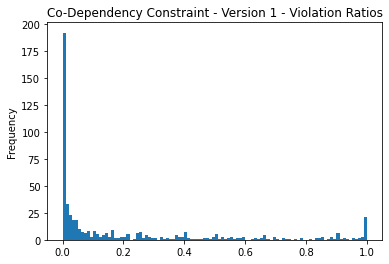

In [37]:
codepConstDF1['violation_ratio'].plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 1 - Violation Ratios")

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 1 - Violation Ratios <= 0.5')

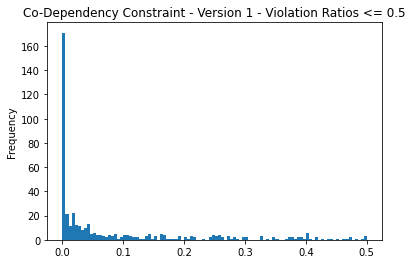

In [38]:
codepConstDF1[codepConstDF1['violation_ratio'] <= 0.5].violation_ratio.plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 1 - Violation Ratios <= 0.5")

In [39]:
print(f"No. of properties whose violation ratio is greater than mean: {sum(codepConstDF1['violation_ratio'] >= 3.539484)}/{len(codepConstDF1)}")

No. of properties whose violation ratio is greater than mean: 0/534


In [40]:
codepConstDF1.to_csv('../../allConstraintsAnalysis_WRemoved_Final/codepConstDFAnalysis.csv')

#### Version 2 - Mand Normal

In [41]:
import pandas as pd
codepConstDF2 = pd.DataFrame(codepConstViolations['Mand_Normal']).T

In [42]:
codepConstDF2

,correct,incorrect,paths
P1018,186,16,[../../allConstraintsAnalysis_WRemoved_Final/c...
P1533,8328,9693,[../../allConstraintsAnalysis_WRemoved_Final/c...
P2009,1036,17,[../../allConstraintsAnalysis_WRemoved_Final/c...
P240,25801,9,[../../allConstraintsAnalysis_WRemoved_Final/c...
P3816,31,10,[../../allConstraintsAnalysis_WRemoved_Final/c...
...,...,...,...
P3648,7,0,[../../allConstraintsAnalysis_WRemoved_Final/c...
P3701,72,1,[../../allConstraintsAnalysis_WRemoved_Final/c...
P3713,359,1,[../../allConstraintsAnalysis_WRemoved_Final/c...
P3744,377,1,[../../allConstraintsAnalysis_WRemoved_Final/c...


In [43]:
codepConstDF2['violation_ratio'] = codepConstDF2.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)

In [44]:
codepConstDF2.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2308,0,51,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P2916,0,2,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P5448,0,23,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P5447,0,24,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P2304,0,1,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P2307,0,2,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P2309,0,55,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P4680,0,2,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P2310,0,4,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0
P2842,0,1,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.0


In [45]:
codepConstDF2.sort_values(by=['incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2214,2989348,721476,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.194425
P433,31113458,436995,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.013851
P275,7295,163856,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.957377
P2860,174842113,152425,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.000871
P1435,2121637,92401,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.041734
P708,45718,57276,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.556110
P197,122018,52917,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.302495
P1598,40600,49329,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.548533
P1111,1,46803,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.999979
P856,1451949,44006,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.029417


In [46]:
codepConstDF2['violation_ratio'].describe()

count    475.000000
mean       0.177493
std        0.289214
min        0.000000
25%        0.000966
50%        0.023847
75%        0.214528
max        1.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 2 - Violation Ratios')

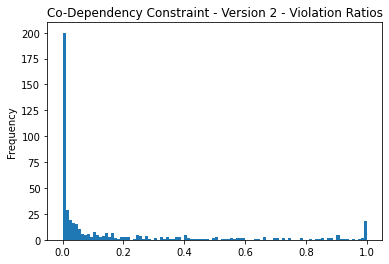

In [47]:
codepConstDF2['violation_ratio'].plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 2 - Violation Ratios")

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 2 - Violation Ratios <= 0.5')

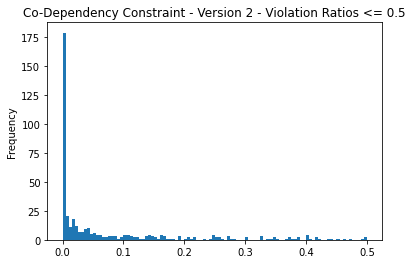

In [48]:
codepConstDF2[codepConstDF2['violation_ratio'] <= 0.5].violation_ratio.plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 2 - Violation Ratios <= 0.5")

In [49]:
print(f"No. of properties whose violation ratio is greater than mean: {sum(codepConstDF2['violation_ratio'] >= 2.290915)}/{len(codepConstDF2)}")

No. of properties whose violation ratio is greater than mean: 0/475


#### Version 3 - Mand

In [50]:
import pandas as pd
codepConstDF3 = pd.DataFrame(codepConstViolations['Mand']).T

In [51]:
codepConstDF3

,correct,incorrect,paths
P564,18887,5,[../../allConstraintsAnalysis_WRemoved_Final/c...
P1081,12693,0,[../../allConstraintsAnalysis_WRemoved_Final/c...
P5982,1328,0,[../../allConstraintsAnalysis_WRemoved_Final/c...
P1087,3774635,1210,[../../allConstraintsAnalysis_WRemoved_Final/c...
P613,70608,5,[../../allConstraintsAnalysis_WRemoved_Final/c...
...,...,...,...
P5105,2060,0,[../../allConstraintsAnalysis_WRemoved_Final/c...
P517,248,0,[../../allConstraintsAnalysis_WRemoved_Final/c...
P521,1757,0,[../../allConstraintsAnalysis_WRemoved_Final/c...
P555,17395,2,[../../allConstraintsAnalysis_WRemoved_Final/c...


In [52]:
codepConstDF3['violation_ratio'] = codepConstDF3.apply(lambda p: p.incorrect / p.correct if p.correct != 0 else p.incorrect/100, axis=1)

In [53]:
codepConstDF3.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P5051,2,79,[../../allConstraintsAnalysis_WRemoved_Final/c...,39.500000
P4341,8,1,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.125000
P2095,38,3,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.078947
P990,1089,44,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.040404
P3931,2316,68,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.029361
P246,174,5,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.028736
P1713,2935,79,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.026917
P141,131232,3270,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.024918
P1731,382,8,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.020942
P2009,1036,17,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.016409


In [54]:
codepConstDF3.loc['P1713']

correct                                                         2935
incorrect                                                         79
paths              [../../allConstraintsAnalysis_WRemoved_Final/c...
violation_ratio                                             0.026917
Name: P1713, dtype: object

In [55]:
!head ../../allConstraintsAnalysis_WRemoved_Final/codependencyConstraint_Final/Mand/claims.P1713.incorrect.tsv

head: cannot open ‘../../allConstraintsAnalysis_WRemoved_Final/codependencyConstraint_Final/Mand/claims.P1713.incorrect.tsv’ for reading: No such file or directory


In [56]:
!cat ../../allConstraintsAnalysis_WRemoved_Final/codependencyConstraint/Mand/claims.P1713.incorrect.tsv

id	node1	label	node2	node2;wikidatatype
Q4681882-P1713-d878eb-9fff460e-0	Q4681882	P1713	"https://heightnetworth.com/adele-givens-net-worth-2020/"	url
Q1763529-P1713-c190308f-q1763529$ffe0aa48-c924-4913-ad50-343dc2d666f1-0	Q1763529	P1713	http://www.bundestag.de/bundestag/abgeordnete18/biografien/H/heck_stefan/258446	url
Q2571287-P1713-6ac225c1-q2571287$bb1e6912-f58f-4106-be9c-55ad68bde759-0	Q2571287	P1713	http://www.bundestag.de/bundestag/abgeordnete18/biografien/L/lorenz_wilfried/258666	url
Q41019201-P1713-16045f49-q41019201$f550afb5-9a1e-4e19-b3cf-7cacc61a2e9e-0	Q41019201	P1713	https://www.bundestag.de/abgeordnete/biografien/P/-/522580	url
Q41105197-P1713-5ed2f31e-q41105197$d493bc2d-023b-4e2f-babc-221a3e720054-0	Q41105197	P1713	https://www.bundestag.de/abgeordnete/biografien/S/-/523620	url
Q41160336-P1713-72b7c975-q41160336$7b946af4-7cb4-4dc8-8a98-6534fb729a4a-0	Q41160336	P1713	https://www.bundestag.de/abgeordnete/biografien/C/-/518870	url
Q41356018-P1713-02640366-q41356018$5e59f8fa-c

In [57]:
codepConstDF3.sort_values(by=['incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P141,131232,3270,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.024918
P1087,3774635,1210,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.000321
P7959,657006,322,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.000490
P5051,2,79,[../../allConstraintsAnalysis_WRemoved_Final/c...,39.500000
P1713,2935,79,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.026917
P3931,2316,68,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.029361
P451,12167,50,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.004109
P915,28966,47,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.001623
P197,174888,44,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.000252
P990,1089,44,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.040404


In [58]:
codepConstDF3['violation_ratio'].describe()

count    79.000000
mean      0.506010
std       4.443448
min       0.000000
25%       0.000000
50%       0.000260
75%       0.002110
max      39.500000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 3 - Violation Ratios')

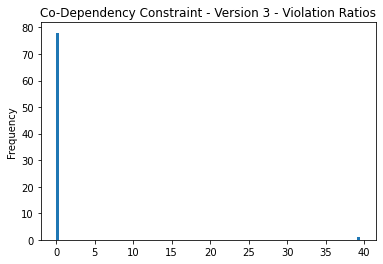

In [59]:
codepConstDF3['violation_ratio'].plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 3 - Violation Ratios")

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 3 - Violation Ratios <= 0.0005')

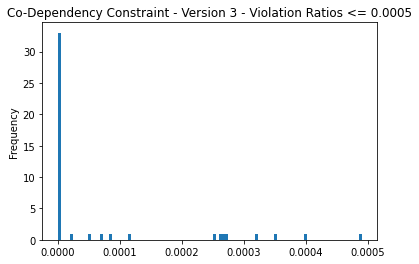

In [60]:
codepConstDF3[codepConstDF3['violation_ratio'] <= 0.0005].violation_ratio.plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 3 - Violation Ratios <= 0.0005")

In [61]:
print(f"No. of properties whose violation ratio is greater than mean: {sum(codepConstDF3['violation_ratio'] >= 0.922928)}/{len(codepConstDF3)}")

No. of properties whose violation ratio is greater than mean: 1/79


#### Version 4 - Normal

In [62]:
import pandas as pd
codepConstDF4 = pd.DataFrame(codepConstViolations['Normal']).T

In [63]:
codepConstDF4

,correct,incorrect,paths
P1018,186,16,[../../allConstraintsAnalysis_WRemoved_Final/c...
P1539,243577,551,[../../allConstraintsAnalysis_WRemoved_Final/c...
P209,163,1,[../../allConstraintsAnalysis_WRemoved_Final/c...
P574,5524,92,[../../allConstraintsAnalysis_WRemoved_Final/c...
P746,941,325,[../../allConstraintsAnalysis_WRemoved_Final/c...
...,...,...,...
P410,138058,813,[../../allConstraintsAnalysis_WRemoved_Final/c...
P411,7629,5541,[../../allConstraintsAnalysis_WRemoved_Final/c...
P413,389145,35536,[../../allConstraintsAnalysis_WRemoved_Final/c...
P418,96,11,[../../allConstraintsAnalysis_WRemoved_Final/c...


In [64]:
codepConstDF4['violation_ratio'] = codepConstDF4.apply(lambda p: p.incorrect / p.correct if p.correct != 0 else p.incorrect/100, axis=1)

In [65]:
codepConstDF4.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P1111,1,46803,[../../allConstraintsAnalysis_WRemoved_Final/c...,46803.000000
P1995,89,11360,[../../allConstraintsAnalysis_WRemoved_Final/c...,127.640449
P4501,425,22684,[../../allConstraintsAnalysis_WRemoved_Final/c...,53.374118
P768,297,15346,[../../allConstraintsAnalysis_WRemoved_Final/c...,51.670034
P275,7295,163856,[../../allConstraintsAnalysis_WRemoved_Final/c...,22.461412
P2306,1,15,[../../allConstraintsAnalysis_WRemoved_Final/c...,15.000000
P3912,312,3775,[../../allConstraintsAnalysis_WRemoved_Final/c...,12.099359
P2248,4025,41608,[../../allConstraintsAnalysis_WRemoved_Final/c...,10.337391
P2303,4,40,[../../allConstraintsAnalysis_WRemoved_Final/c...,10.000000
P2325,4079,40619,[../../allConstraintsAnalysis_WRemoved_Final/c...,9.958078


In [66]:
# list(codepConstDF4.sort_values(by=['violation_ratio'],ascending=False).head(5).paths)

In [67]:
codepConstDF4.sort_values(by=['incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2214,2989348,721476,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.241349
P433,31113458,436995,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.014045
P275,7295,163856,[../../allConstraintsAnalysis_WRemoved_Final/c...,22.461412
P2860,174842113,152425,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.000872
P1435,2121637,92401,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.043552
P708,45718,57276,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.252811
P197,122018,52917,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.433682
P1598,40600,49329,[../../allConstraintsAnalysis_WRemoved_Final/c...,1.215000
P1111,1,46803,[../../allConstraintsAnalysis_WRemoved_Final/c...,46803.000000
P856,1451949,44006,[../../allConstraintsAnalysis_WRemoved_Final/c...,0.030308


In [68]:
codepConstDF4['violation_ratio'].describe()

count      424.000000
mean       111.550177
std       2272.909916
min          0.000000
25%          0.001966
50%          0.036278
75%          0.260204
max      46803.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 4 - Violation Ratios')

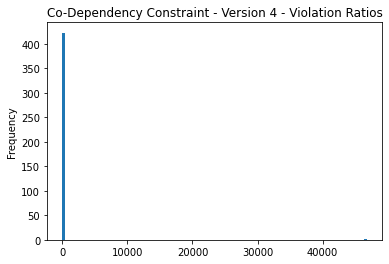

In [69]:
codepConstDF4['violation_ratio'].plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 4 - Violation Ratios")

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 4 - Violation Ratios <= 0.5')

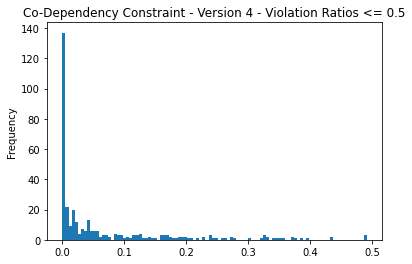

In [70]:
codepConstDF4[codepConstDF4['violation_ratio'] <= 0.5].violation_ratio.plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 4 - Violation Ratios <= 0.5")

In [71]:
print(f"No. of properties whose violation ratio is greater than mean: {sum(codepConstDF4['violation_ratio'] >= 2.414703)}/{len(codepConstDF4)}")

No. of properties whose violation ratio is greater than mean: 29/424


### Find out time required

In [ ]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
timesVersion = {"MSN": [], "MN": [], "M": [], "N": [], "S": []}
filePath = '/data/wd-correctness/propertiesSplit_WRemoved_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("timeLog_codepConst_"):
        ver = filename.split('_')[2]
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes
        timesVersion[ver] += tempTimes
print(pd.Series(times).describe())

In [ ]:
print(pd.Series(timesVersion['MSN']).describe())

In [ ]:
print(pd.Series(timesVersion['MN']).describe())

In [ ]:
print(pd.Series(timesVersion['M']).describe())

In [ ]:
print(pd.Series(timesVersion['N']).describe())

## Symmetric Constraint (Q21510862)

This constraint says, if node1 has a property with this constraint, then both `(node1)-[prop]->(node2)` and `(node2)-[prop]->(node1)` must be present with few exceptions

### Constraints File

In [25]:
!kgtk --debug query -i ../../gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz \
    ../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz \
    --match "p: (nodeProp1)-[nodePropEdge:P2302]->(:Q21510862)" \
    -o ../../constraintsOP/symmetricConstraint/claims.constraints_list.tsv \
    --graph-cache ~/sqlite3_caches/temp1345.valuetype.sqlite3.db

[2021-04-15 07:17:19 query]: SQL Translation:
---------------------------------------------
  SELECT *
     FROM graph_1 AS graph_1_c1
     WHERE graph_1_c1."label"=?
     AND graph_1_c1."node2"=?
  PARAS: ['P2302', 'Q21510862']
---------------------------------------------


In [26]:
import pandas as pd
qualiDF = pd.read_csv("../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz",sep='\t')
constDF = pd.read_csv("../../constraintsOP/symmetricConstraint/claims.constraints_list.tsv",sep='\t')

In [27]:
constDF2 = constDF.set_index('id').join(qualiDF.set_index('node1'),rsuffix='_qualifier').drop(columns=['id', 'node2;wikidatatype_qualifier', 'rank', 'node2', 'label', 'node2;wikidatatype']).rename(columns={'label_qualifier':'label', 'node2_qualifier': 'node2'})
constDF2 = constDF2.reset_index()
constDF2 = constDF2.rename(columns={'index':'id'})
constDF2['label'] = constDF2.label.fillna("P2316")
constDF2['node2'] = constDF2.node2.fillna("Normal")

In [28]:
constDF2.to_csv("../../constraintsOP/symmetricConstraint/claims.constraints_all.tsv",sep="\t",index=False)

In [29]:
import pandas as pd
import math
dfItemRequires = pd.read_csv('../../constraintsOP/symmetricConstraint/claims.constraints_all.tsv',sep='\t')

In [30]:
dfItemRequires = dfItemRequires.groupby(['id','node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [31]:
dfItemRequires['label'].unique()

array(['P2316', 'P2303'], dtype=object)

In [32]:
dfItemRequires['label'].value_counts()

P2316    42
P2303     3
Name: label, dtype: int64

In [33]:
#Reference: https://stackoverflow.com/a/17298454
# dfItemRequires.pivot_table('node2', ['node1', 'id'], 'label')
dfItemRequires = dfItemRequires.pivot(index=['node1','id'], columns='label', values='node2')

In [34]:
dfItemRequires.head()

,label,P2303,P2316
node1,id,,
P1322,P1322-P2302-Q21510862-85dea891-0,NaN,[Normal]
P1327,P1327-P2302-Q21510862-a3c3a094-0,NaN,[Normal]
P1382,P1382-P2302-Q21510862-f6bcfecf-0,NaN,[Normal]
P1560,P1560-P2302-Q21510862-fabecaeb-0,NaN,[Q21502408]
P1639,P1639-P2302-Q21510862-384edcd4-0,NaN,[Q21502408]


In [35]:
dfItemRequires = dfItemRequires.droplevel(1)

In [36]:
dfItemRequires.head()

label,P2303,P2316
node1,,
P1322,NaN,[Normal]
P1327,NaN,[Normal]
P1382,NaN,[Normal]
P1560,NaN,[Q21502408]
P1639,NaN,[Q21502408]


### Query Generator

In [37]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

folderName = 'symmetricConstraint'
shellFileSuffix = 'symmConst_Validator_'
graph_cache_prefix = 'symm_new_11_1_'

for row in tqdm(dfItemRequires.iterrows()):
#     try:
        prop = row[0]
        constraint = row[1]
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        if type(constraint['P2316']) == list:
            if constraint['P2316'][0] == 'Q21502408':
                sfname = 'mandatory'
            elif constraint['P2316'][0] == 'Q62026391':
                sfname = 'suggestion'
            elif constraint['P2316'][0] == 'Normal':
                sfname = 'normal'
        else:
            sfname = 'normal'
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
                
        command = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
                    ../../propertiesSplit_WRemoved_Final/claims."+ prop +".copy2.tsv \
                    --match 'tsv: (node1)-[nodeProp]->(node2), copy2: (node2)-[]->(node1)' "
        
        os.system("cp ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv ../../propertiesSplit_WRemoved_Final/claims."+ prop +".copy2.tsv")
        
        if cnt % 60 == 0:
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        command
        if type(constraint['P2303']) != list: # Exceptions not present
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/"+graph_cache_prefix+"_" + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n"
#             print(command)
            fOP.write(command)
        else:
            excptns = constraint['P2303']
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/"+graph_cache_prefix+"_" + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv; "
#             print(command)
            fOP.write(command)
            
            command = " kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims." + prop + ".correct_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/"+graph_cache_prefix+"_" + str(fCnt) + ".sqlite3.db; "
#             print(command)
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims." + prop + ".correct_exceptions.tsv \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".incorrect.tsv; "
#             print(command)
            fOP.write(command)
            
            command = " kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n"
#             print(command)
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)

0it [00:00, ?it/s]

In [38]:
cnt

39

In [59]:
# import os
# for i in range(1,3):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/symmConst_Validator_"+str(i)+".sh")

### Analyze Violations

In [72]:
import pandas as pd
import os
from tqdm.notebook import tqdm

symmConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt 

symmConstViolations = {}
symmConstPropList = set()

# codepConstViolationsSummary = {}


filePath = "../../allConstraintsAnalysis_WRemoved_Final/symmetricConstraint/"
for folder in tqdm(iter(['mandatory','normal','suggestion'])):
    for filename in tqdm(os.listdir(filePath + folder)):
        prop = filename.split(".")[1]
        correctness = filename.split(".")[2]
        if correctness not in ['correct','incorrect']:
            continue
        symmConstPropList.add(prop)
        count1 = countLines(filePath+folder+'/'+filename)
        if folder not in symmConstViolations:
            symmConstViolations[folder] = {}
        if prop not in symmConstViolations[folder]:
            symmConstViolations[folder][prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        symmConstViolations[folder][prop][correctness] = count1
        symmConstViolations[folder][prop]['paths'].append(filePath+folder+'/'+filename)

0it [00:00, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [73]:
len(symmConstPropList)

39

In [74]:
symmConstViolationsSummary = {}
for folder in tqdm(iter(['mandatory','normal','suggestion'])):
    symmConstViolationsSummary[folder] = {'correct': 0, 'incorrect': 0}
    for prop in symmConstViolations[folder].keys():
        symmConstViolationsSummary[folder]['correct'] += symmConstViolations[folder][prop]['correct']
        symmConstViolationsSummary[folder]['incorrect'] += symmConstViolations[folder][prop]['incorrect']
    symmConstViolationsSummary[folder]['total'] = symmConstViolationsSummary[folder]['correct'] + symmConstViolationsSummary[folder]['incorrect']
    symmConstViolationsSummary[folder]['percIncorrect'] = symmConstViolationsSummary[folder]['incorrect'] / symmConstViolationsSummary[folder]['total'] * 100
    symmConstViolationsSummary[folder]['propCount'] = len(symmConstViolations[folder].keys())

0it [00:00, ?it/s]

In [75]:
symmConstViolationsSummary

{'mandatory': {'correct': 7720,
  'incorrect': 61,
  'total': 7781,
  'percIncorrect': 0.7839609304716617,
  'propCount': 5},
 'normal': {'correct': 9553481,
  'incorrect': 7602206,
  'total': 17155687,
  'percIncorrect': 44.313037420186085,
  'propCount': 31},
 'suggestion': {'correct': 806179,
  'incorrect': 59278,
  'total': 865457,
  'percIncorrect': 6.849329313876947,
  'propCount': 3}}

In [76]:
noOfStmts = 0
for fold in symmConstViolationsSummary.keys():
    noOfStmts += symmConstViolationsSummary[fold]['total']
noOfStmts

18028925

In [77]:
symmConstDF1 = pd.DataFrame(symmConstViolations['mandatory']).T
symmConstDF1['violation_ratio'] = symmConstDF1.apply(lambda p: p.incorrect / (p.incorrect + p.correct), axis=1)
symmConstDF1.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2152,80,1,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.012346
P1639,2094,26,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.012264
P1560,3459,33,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.009450
P3364,1806,1,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.000553
P6185,281,0,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.000000


In [78]:
symmConstDF2 = pd.DataFrame(symmConstViolations['suggestion']).T
symmConstDF2['violation_ratio'] = symmConstDF2.apply(lambda p: p.incorrect / (p.incorrect + p.correct), axis=1)
symmConstDF2.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2789,104551,24812,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.191801
P1889,530234,30928,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.055114
P197,171394,3538,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.020225


In [79]:
symmConstDF3 = pd.DataFrame(symmConstViolations['normal']).T
symmConstDF3['violation_ratio'] = symmConstDF3.apply(lambda p: p.incorrect / (p.incorrect + p.correct), axis=1)
symmConstDF3.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P5974,0,1,[../../allConstraintsAnalysis_WRemoved_Final/s...,1.000000
P5188,0,5,[../../allConstraintsAnalysis_WRemoved_Final/s...,1.000000
P1706,12,97,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.889908
P521,421,1336,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.760387
P2652,498,911,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.646558
P684,7523178,7524749,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.500052
P8702,6,2,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.250000
P1382,10837,2911,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.211740
P3032,1730,358,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.171456
P2293,12492,2321,[../../allConstraintsAnalysis_WRemoved_Final/s...,0.156687


In [80]:
# !head ../../allConstraintsAnalysis_WRemoved_Final/symmetricConstraint/normal/claims.P3032.incorrect.tsv



Text(0.5, 1.0, 'Symmetric Normal Constraint - Violation Ratios')

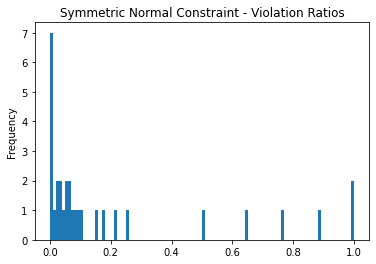

In [81]:
symmConstDF3.sort_values(by=['violation_ratio'],ascending=False)['violation_ratio'].plot.hist(bins=100).set_title("Symmetric Normal Constraint - Violation Ratios")

In [82]:
pd.concat([symmConstDF1, symmConstDF2, symmConstDF3]).to_csv('../../allConstraintsAnalysis_WRemoved_Final/symmConstDFAnalysis.csv')

In [83]:
!kgtk cat -i ../../temp/claims.P1560.correct.tsv \
    ../../temp/claims.P1560.incorrect.tsv \
    -o ../../temp/claims.P1560.merged.tsv

In [84]:
!kgtk ifnotexists -i ../../temp/claims.P1560.merged.tsv \
    --filter-on ../../propertiesSplit_WRemoved_FinalWRemoved3/claims.P1560.tsv

[Errno 2] No such file or directory: '../../propertiesSplit_WRemoved_FinalWRemoved3/claims.P1560.tsv'


### Find out time required

In [11]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
filePath = '/data/wd-correctness/propertiesSplit_WRemoved_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("symmConst_Validator_"):
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes

  0%|          | 0/108 [00:00<?, ?it/s]

In [12]:
print(pd.Series(times).describe())

count     38.000000
mean      15.315868
std       61.526228
min        2.069000
25%        2.617750
50%        3.003000
75%        5.889250
max      383.135000
dtype: float64


Text(0.5, 1.0, 'Distribution of times (in s) taken for symmetric constraint checks')

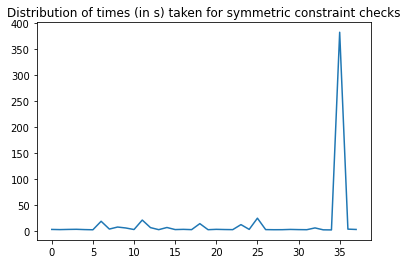

In [13]:
import seaborn as sns
sns.lineplot(data=pd.Series(times)).set_title("Distribution of times (in s) taken for symmetric constraint checks")

## Inverse Constraint (Q21510855)

This constraint says, if node1 has a property with this constraint, then both `(node1)-[prop]->(node2)` and `(node2)-[prop]->(node1)` must be present with few exceptions

### Constraints File

In [39]:
!kgtk --debug query -i ../../gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz \
    ../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz \
    --match "p: (nodeProp1)-[nodePropEdge:P2302]->(:Q21510855)" \
    -o ../../constraintsOP/inverseConstraint/claims.constraints_list.tsv \
    --graph-cache ~/sqlite3_caches/temp1345.valuetype.sqlite3.db

[2021-04-15 07:17:37 query]: SQL Translation:
---------------------------------------------
  SELECT *
     FROM graph_1 AS graph_1_c1
     WHERE graph_1_c1."label"=?
     AND graph_1_c1."node2"=?
  PARAS: ['P2302', 'Q21510855']
---------------------------------------------


In [40]:
!head ../../constraintsOP/inverseConstraint/claims.constraints_list.tsv

id	node1	label	node2	rank	node2;wikidatatype
P1026-P2302-Q21510855-adc83b86-0	P1026	P2302	Q21510855	normal	wikibase-item
P1029-P2302-Q21510855-6b55e057-0	P1029	P2302	Q21510855	normal	wikibase-item
P115-P2302-Q21510855-f7aa0b78-0	P115	P2302	Q21510855	normal	wikibase-item
P1151-P2302-Q21510855-0d9aa9c6-0	P1151	P2302	Q21510855	normal	wikibase-item
P1204-P2302-Q21510855-e3d53bb6-0	P1204	P2302	Q21510855	normal	wikibase-item
P1283-P2302-Q21510855-0e7699bb-0	P1283	P2302	Q21510855	normal	wikibase-item
P1308-P2302-Q21510855-2aba96b7-0	P1308	P2302	Q21510855	normal	wikibase-item
P1365-P2302-Q21510855-c809b758-0	P1365	P2302	Q21510855	normal	wikibase-item
P1366-P2302-Q21510855-eee12ef8-0	P1366	P2302	Q21510855	normal	wikibase-item


In [41]:
import pandas as pd
qualiDF = pd.read_csv("../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz",sep='\t')
constDF = pd.read_csv("../../constraintsOP/inverseConstraint/claims.constraints_list.tsv",sep='\t')

In [42]:
constDF2 = constDF.set_index('id').join(qualiDF.set_index('node1'),rsuffix='_qualifier').drop(columns=['id', 'node2;wikidatatype_qualifier', 'rank', 'node2', 'label', 'node2;wikidatatype']).rename(columns={'label_qualifier':'label', 'node2_qualifier': 'node2'})
constDF2 = constDF2.reset_index()
constDF2 = constDF2.rename(columns={'index':'id'})
constDF2['label'] = constDF2.label.fillna("P2316")
constDF2['node2'] = constDF2.node2.fillna("Normal")

In [43]:
constDF2.to_csv("../../constraintsOP/inverseConstraint/claims.constraints_all.tsv",sep="\t",index=False)

In [44]:
import pandas as pd
import math
dfItemRequires = pd.read_csv('../../constraintsOP/inverseConstraint/claims.constraints_all.tsv',sep='\t')

In [45]:
dfItemRequires = dfItemRequires.groupby(['id','node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [46]:
dfItemRequires['label'].unique()

array(['P2306', 'P2316', 'P4155', 'P2303'], dtype=object)

In [47]:
dfItemRequires['label'].value_counts()

P2306    110
P2316     10
P2303      2
P4155      1
Name: label, dtype: int64

In [48]:
#Reference: https://stackoverflow.com/a/17298454
# dfItemRequires.pivot_table('node2', ['node1', 'id'], 'label')
dfItemRequires = dfItemRequires.pivot(index=['node1','id'], columns='label', values='node2')

In [49]:
dfItemRequires.head()

,label,P2303,P2306,P2316,P4155
node1,id,,,,
P1026,P1026-P2302-Q21510855-adc83b86-0,NaN,[P50],NaN,NaN
P1029,P1029-P2302-Q21510855-6b55e057-0,NaN,[P5096],NaN,NaN
P115,P115-P2302-Q21510855-f7aa0b78-0,NaN,[P466],NaN,NaN
P1151,P1151-P2302-Q21510855-0d9aa9c6-0,NaN,[P1204],[Q21502408],NaN
P1204,P1204-P2302-Q21510855-e3d53bb6-0,NaN,[P1151],NaN,NaN


In [50]:
dfItemRequires = dfItemRequires.droplevel(1)

In [51]:
dfItemRequires.head()

label,P2303,P2306,P2316,P4155
node1,,,,
P1026,NaN,[P50],NaN,NaN
P1029,NaN,[P5096],NaN,NaN
P115,NaN,[P466],NaN,NaN
P1151,NaN,[P1204],[Q21502408],NaN
P1204,NaN,[P1151],NaN,NaN


### Query Generator

In [52]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0
fOP = None

folderName = 'inverseConstraint'
shellFileSuffix = 'invConst_Validator_'
graph_cache_file_prefix = "inv_new_11_1_"

for prop, constraint in tqdm(dfItemRequires.iterrows()):
#     try:
        
        if type(constraint['P2316']) == list:
            if constraint['P2316'][0] == 'Q21502408':
                subFolderName = "mandatory"
            elif constraint['P2316'][0] == 'Q62026391':
                subFolderName = "suggestion"
        else:
            subFolderName = "normal"
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
            
        prop2 = constraint['P2306']

        if type(prop2) != list:
            continue
        prop2 = prop2[0]

        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
            print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
            continue
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
            
        command = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
                        ../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv \
                        --match '"+ \
                        f"{prop}: (node1)-[nodeProp]->(node2), {prop2}: (node2)-[]->(node1)' "

        if type(constraint['P2303']) != list: # Exceptions not present
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n"
#             print(command)
            fOP.write(command)
        else:
            excptns = set(constraint['P2303'])
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv; "
#             print(command)
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
#             print(command)        
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
#             print(command)
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt; \n"
#             print(command)
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

0it [00:00, ?it/s]

In [53]:
cnt

110

In [60]:
# import os
# for i in range(1,7):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/invConst_Validator_"+str(i)+".sh")

### Analyze Violations

In [85]:
import pandas as pd
import os
from tqdm.notebook import tqdm

invConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt

invConstViolations = {}
invConstPropList = set()

# codepConstViolationsSummary = {}


filePath = "../../allConstraintsAnalysis_WRemoved_Final/inverseConstraint/"
for folder in tqdm(iter(['mandatory','normal','suggestion'])):
    for filename in tqdm(os.listdir(filePath + folder)):
        prop = filename.split(".")[1]
        correctness = filename.split(".")[2]
        if correctness not in ['correct','incorrect']:
            continue
        invConstPropList.add(prop)
        count1 = countLines(filePath+folder+'/'+filename)
        if folder not in invConstViolations:
            invConstViolations[folder] = {}
        if prop not in invConstViolations[folder]:
            invConstViolations[folder][prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        invConstViolations[folder][prop][correctness] = count1
        invConstViolations[folder][prop]['paths'].append(filePath+folder+'/'+filename)

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [86]:
len(invConstPropList)

110

In [87]:
invConstViolationsSummary = {}
for folder in tqdm(iter(['mandatory','normal','suggestion'])):
    invConstViolationsSummary[folder] = {'correct': 0, 'incorrect': 0}
    for prop in invConstViolations[folder].keys():
        invConstViolationsSummary[folder]['correct'] += invConstViolations[folder][prop]['correct']
        invConstViolationsSummary[folder]['incorrect'] += invConstViolations[folder][prop]['incorrect']
    invConstViolationsSummary[folder]['total'] = invConstViolationsSummary[folder]['correct'] + invConstViolationsSummary[folder]['incorrect']
    invConstViolationsSummary[folder]['percIncorrect'] = invConstViolationsSummary[folder]['incorrect'] / invConstViolationsSummary[folder]['total'] * 100
    invConstViolationsSummary[folder]['propCount'] = len(invConstViolations[folder].keys())

0it [00:00, ?it/s]

In [88]:
invConstViolationsSummary

{'mandatory': {'correct': 6872,
  'incorrect': 170,
  'total': 7042,
  'percIncorrect': 2.4140869071286564,
  'propCount': 6},
 'normal': {'correct': 7489249,
  'incorrect': 381880,
  'total': 7871129,
  'percIncorrect': 4.851654699090817,
  'propCount': 100},
 'suggestion': {'correct': 2150990,
  'incorrect': 107016,
  'total': 2258006,
  'percIncorrect': 4.739402818238747,
  'propCount': 4}}

In [89]:
noOfStmts = 0
for fold in invConstViolationsSummary.keys():
    noOfStmts += invConstViolationsSummary[fold]['total']
noOfStmts

10136177

In [90]:
invConstDF1 = pd.DataFrame(invConstViolations['mandatory']).T
invConstDF1['violation_ratio'] = invConstDF1.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)
invConstDF1.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2673,839,70,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.077008
P4147,286,8,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.027211
P450,1779,30,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.016584
P1151,1803,30,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.016367
P2033,1879,28,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.014683
P4149,286,4,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.013793


In [91]:
invConstDF2 = pd.DataFrame(invConstViolations['suggestion']).T
invConstDF2['violation_ratio'] = invConstDF2.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)
invConstDF2.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P1434,3677,5071,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.579675
P155,1036647,56650,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.051816
P156,1036636,44187,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.040883
P629,74030,1108,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.014746


In [92]:
invConstDF3 = pd.DataFrame(invConstViolations['normal']).T
invConstDF3['violation_ratio'] = invConstDF3.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)
invConstDF3.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P1605,13,191,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.936275
P3448,605,4595,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.883654
P926,1,6,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.857143
P1029,490,2662,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.844543
P925,1,5,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.833333
P115,6948,25081,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.783072
P5134,23,54,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.701299
P3816,14,27,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.658537
P1283,1405,2479,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.638260
P8625,9,15,[../../allConstraintsAnalysis_WRemoved_Final/i...,0.625000


In [93]:
!head ../../allConstraintsAnalysis_WRemoved_Final/inverseConstraint/normal/claims.P925.incorrect.tsv

id	node1	label	node2	node2;wikidatatype
Q1133903-P925-Q18707-eae3a579-0	Q1133903	P925	Q18707	wikibase-item
Q1570272-P925-Q7135001-5dbdce8c-0	Q1570272	P925	Q7135001	wikibase-item
Q301613-P925-Q7135001-528c29b2-0	Q301613	P925	Q7135001	wikibase-item
Q452595-P925-Q864951-c5b34e11-0	Q452595	P925	Q864951	wikibase-item
Q5064084-P925-Q4117017-76545a06-0	Q5064084	P925	Q4117017	wikibase-item


Text(0.5, 1.0, 'Symmetric Normal Constraint - Violation Ratios')

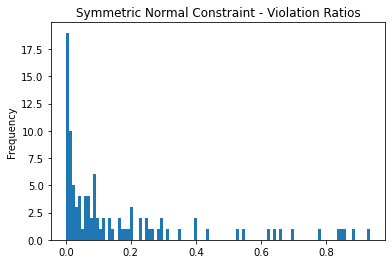

In [94]:
invConstDF3.sort_values(by=['violation_ratio'],ascending=False)['violation_ratio'].plot.hist(bins=100).set_title("Symmetric Normal Constraint - Violation Ratios")

In [95]:
pd.concat([invConstDF1, invConstDF2, invConstDF3]).to_csv('../../allConstraintsAnalysis_WRemoved_Final/invConstDFAnalysis.csv')

### Find out time required

In [55]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
filePath = '/data/wd-correctness/propertiesSplit_WRemoved_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("invConst_Validator_new3"):
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes

  0%|          | 0/122 [00:00<?, ?it/s]

In [56]:
print(pd.Series(times).describe())

count    110.000000
mean       7.526318
std       11.686634
min        1.519000
25%        2.624000
50%        3.298500
75%        6.463250
max       80.846000
dtype: float64


Text(0.5, 1.0, 'Distribution of times (in s) taken for symmetric constraint checks')

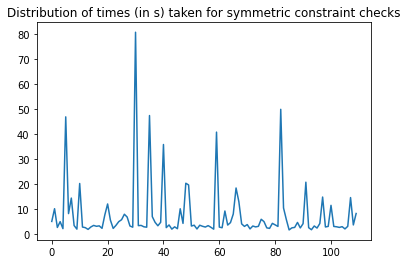

In [57]:
import seaborn as sns
sns.lineplot(data=pd.Series(times)).set_title("Distribution of times (in s) taken for symmetric constraint checks")

# Combine Plots for constraints

In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

typeConstDF = pd.read_csv("../../allConstraintsAnalysis_WRemoved_Final/typeConstDFAnalysis.csv")
typeConstDF = typeConstDF.set_index(typeConstDF.iloc[:, 0])

valTypeConstDF = pd.read_csv("../../allConstraintsAnalysis_WRemoved_Final/valueTypeConstDFAnalysis.csv")
valTypeConstDF = valTypeConstDF.set_index(valTypeConstDF.iloc[:, 0])

codepConstDF1 = pd.read_csv("../../allConstraintsAnalysis_WRemoved_Final/codepConstDFAnalysis.csv")
codepConstDF1 = codepConstDF1.set_index(codepConstDF1.iloc[:, 0])

symmConstDF = pd.read_csv("../../allConstraintsAnalysis_WRemoved_Final/symmConstDFAnalysis.csv")
symmConstDF = symmConstDF.set_index(symmConstDF.iloc[:, 0])

invConstDF = pd.read_csv("../../allConstraintsAnalysis_WRemoved_Final/invConstDFAnalysis.csv")
invConstDF = invConstDF.set_index(invConstDF.iloc[:, 0])

In [3]:
typeConstDF1 = typeConstDF.add_suffix("_type_const")['violation_ratio_type_const'].rename().sort_values()

In [4]:
valTypeConstDF1 = valTypeConstDF.add_suffix("_valuetype_const")['violation_ratio_valuetype_const'].sort_values()

In [5]:
codepConstDF1_1 = codepConstDF1.add_suffix("_codep_const")['violation_ratio_codep_const'].sort_values()

In [6]:
symmConstDF1_1 = symmConstDF.add_suffix("_symm_const")['violation_ratio_symm_const'].sort_values()

In [7]:
invConstDF1_1 = invConstDF.add_suffix("_inv_const")['violation_ratio_inv_const'].sort_values()

In [8]:
typeConstDF1.index.names = ['property']
typeConstDF1 = typeConstDF1.reset_index().reset_index()
typeConstDF1['index'] = typeConstDF1['index'].apply(lambda p: (p+1) * 100/len(typeConstDF1))
typeConstDF1 = typeConstDF1.set_index('index')[0]

In [9]:
valTypeConstDF1.index.names = ['property']
valTypeConstDF1 = valTypeConstDF1.reset_index().reset_index()
valTypeConstDF1['index'] = valTypeConstDF1['index'].apply(lambda p: (p+1) * 100/len(valTypeConstDF1))
valTypeConstDF1 = valTypeConstDF1.set_index('index')['violation_ratio_valuetype_const']

In [10]:
codepConstDF1_1.index.names = ['property']
codepConstDF1_1 = codepConstDF1_1.reset_index().reset_index()
codepConstDF1_1['index'] = codepConstDF1_1['index'].apply(lambda p: (p+1) * 100/len(codepConstDF1_1))
codepConstDF1_1 = codepConstDF1_1.set_index('index')['violation_ratio_codep_const']

In [11]:
symmConstDF1_1.index.names = ['property']
symmConstDF1_1 = symmConstDF1_1.reset_index().reset_index()
symmConstDF1_1['index'] = symmConstDF1_1['index'].apply(lambda p: (p+1) * 100/len(symmConstDF1_1))
symmConstDF1_1 = symmConstDF1_1.set_index('index')['violation_ratio_symm_const']

In [12]:
invConstDF1_1.index.names = ['property']
invConstDF1_1 = invConstDF1_1.reset_index().reset_index()
invConstDF1_1['index'] = invConstDF1_1['index'].apply(lambda p: (p+1) * 100/len(invConstDF1_1))
invConstDF1_1 = invConstDF1_1.set_index('index')['violation_ratio_inv_const']

In [23]:
typeConstDF2 = [np.percentile(typeConstDF1,i)*100 for i in range(1, 101)]
valTypeConstDF2 = [np.percentile(valTypeConstDF1,i)*100 for i in range(1, 101)]
codepConstDF1_2 = [np.percentile(codepConstDF1_1,i)*100 for i in range(1, 101)]
symmConstDF1_2 = [np.percentile(symmConstDF1_1,i)*100 for i in range(1, 101)]
invConstDF1_2 = [np.percentile(invConstDF1_1,i)*100 for i in range(1, 101)]

In [24]:
constAnalysisDF = pd.DataFrame({'index':list(range(1, 101)), 'type': typeConstDF2, 'value type': valTypeConstDF2, 'irs': codepConstDF1_2, 'symmetric': symmConstDF1_2, 'inverse': invConstDF1_2})

In [25]:
constAnalysisDF = constAnalysisDF.melt('index', var_name='constraint',  value_name='VR')

In [26]:
constAnalysisDF.head()

,index,constraint,VR
0,1,type,0.0
1,2,type,0.0
2,3,type,0.0
3,4,type,0.0
4,5,type,0.0


[Text(0.5, 0, 'Proportion of properties (in %)'),
 Text(0, 0.5, 'Violation Ratio (in %)')]

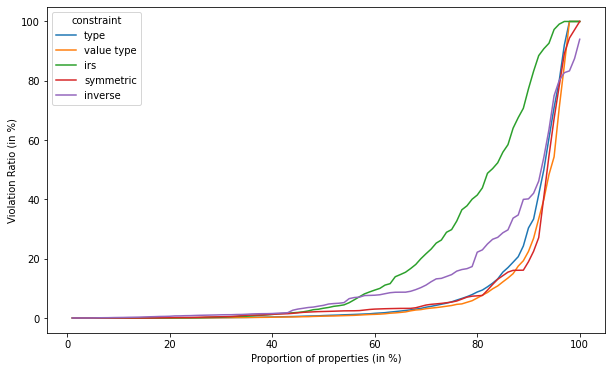

In [33]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='index', y='VR', hue='constraint', data=constAnalysisDF)
ax.set(xlabel="Proportion of properties (in %)", ylabel = "Violation Ratio (in %)")

In [16]:
g = sns.catplot(x="property", y="VR", hue='constraint', data=constAnalysisPlotDF1)

KeyboardInterrupt: 

<AxesSubplot:xlabel='property', ylabel='VR'>

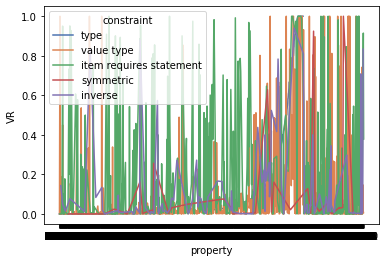

In [19]:
sns.lineplot(x='property',y='VR',hue='constraint',estimator=None,data=constAnalysisPlotDF1,palette='deep')



# Analysis on properties with constraints

In [26]:
!kgtk --debug query -i ../../gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz \
    ../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz \
    --match "p: (nodeProp1)-[nodePropEdge:P2302]->()" \
    -o ../../constraintsOP/claims.constraints_list.tsv \
    --graph-cache ~/sqlite3_caches/temp1345.valuetype.sqlite3.db

[2021-04-03 09:14:12 query]: SQL Translation:
---------------------------------------------
  SELECT *
     FROM graph_1 AS graph_1_c1
     WHERE graph_1_c1."label"=?
  PARAS: ['P2302']
---------------------------------------------


In [39]:
!kgtk unique -i ../../gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz --column node1 -o ../../constraintsOP/claims.propList.tsv

In [42]:
!head ../../constraintsOP/claims.propList.tsv

node1	label	node2
P10	count	17
P1000	count	10
P1001	count	26
P1002	count	9
P1003	count	20
P1004	count	33
P1005	count	21
P1006	count	26
P1007	count	19


In [43]:
import pandas as pd
import os
props = pd.read_csv("../../constraintsOP/claims.constraints_list.tsv", sep='\t')

In [44]:
props2 = props.groupby(['node1']).node2.apply(list)

In [45]:
len(props2)

8100

In [48]:
cnt = 0
totalCnt = 0
for prop in props2.index:
    totalCnt += 1
    if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
        continue
    else:
        cnt += 1
cnt, totalCnt

(2336, 8100)

In [50]:
props2.head(500)

node1
P10      [Q21502404, Q21510851, Q21510852, Q52004125, Q...
P1000                    [Q21510856, Q21510865, Q53869507]
P1001         [Q21502838, Q21503250, Q21510865, Q25796498]
P1002                               [Q21503250, Q21510865]
P1003    [Q19474404, Q21502404, Q21502410, Q21510851, Q...
                               ...                        
P1563    [Q19474404, Q21502404, Q21502410, Q21503247, Q...
P1564    [Q19474404, Q21502404, Q21502410, Q21503247, Q...
P1565    [Q19474404, Q21502404, Q21502410, Q21503247, Q...
P1566    [Q19474404, Q21502404, Q21502410, Q21502838, Q...
P1567    [Q19474404, Q21502404, Q21502410, Q21502838, Q...
Name: node2, Length: 500, dtype: object

In [32]:
import pandas as pd
import os
props2 = pd.read_csv("../../constraintsOP/claims.propList.tsv", sep='\t')

In [33]:
props2 = props2.groupby(['node1']).node2.apply(list)

In [34]:
len(props2)

8193

In [35]:
cnt = 0
totalCnt = 0
for prop in props2.index:
    totalCnt += 1
    if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
        continue
    else:
        cnt += 1
cnt, totalCnt

(2415, 8193)

In [50]:
props2.head(500)

node1
P10      [Q21502404, Q21510851, Q21510852, Q52004125, Q...
P1000                    [Q21510856, Q21510865, Q53869507]
P1001         [Q21502838, Q21503250, Q21510865, Q25796498]
P1002                               [Q21503250, Q21510865]
P1003    [Q19474404, Q21502404, Q21502410, Q21510851, Q...
                               ...                        
P1563    [Q19474404, Q21502404, Q21502410, Q21503247, Q...
P1564    [Q19474404, Q21502404, Q21502410, Q21503247, Q...
P1565    [Q19474404, Q21502404, Q21502410, Q21503247, Q...
P1566    [Q19474404, Q21502404, Q21502410, Q21502838, Q...
P1567    [Q19474404, Q21502404, Q21502410, Q21502838, Q...
Name: node2, Length: 500, dtype: object